In [2]:

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore

Helper imported succesfully


In [21]:
# Closed-loop example using Python controller functions from `experiments/controllers_T2D2.py`

import importlib
from pathlib import Path

# Ensure `pausterization_unit/experiments` is on sys.path so we can import controllers_T2D2
project_root = Path.cwd().resolve().parent  # this notebook lives in pausterization_unit/control_sim
experiments_path = project_root / "experiments"
if str(experiments_path) not in sys.path:
    sys.path.append(str(experiments_path))

controllers_T2D2 = importlib.import_module("controllers_T2D2")

# Initialize Koopman-based controller (loads A, B, C, scalers, EKF, MPC, etc.)
controllers_T2D2.load()
controllers_T2D2.tests()  # optional sanity check, runs one MPC solve

Close to block diagonal? True
Backtransformation equals original A? True
[-0.07570631  2.03002648 -0.10869232  0.19744204  2.20612126  2.81438022
 -1.34864415  1.75370925 -2.23394746  1.33500519  0.11198471  1.37559612
 -1.15713679]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [3]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (44, 44)
B matrix shape: (44, 3)
Scalers loaded for 3 outputs and 3 inputs


In [4]:
# Resolve project paths (repo root assumed to be parent of this script's CWD)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

figures_dir = os.path.join(project_root, 'figures')
os.makedirs(figures_dir, exist_ok=True)

# Local imports from the project
import models  # type: ignore
import helper  # type: ignore

# -----------------------------
# Load matrices, model, scalers
# -----------------------------
matrix_C = False

A = np.load("../data/A_C_False.npy")
B = np.load("../data/B_C_False.npy")
C = np.load("../data/C_C_False.npy")

# Resample A and B from Ts=1 to Ts=10 seconds
Ts_old = 1.0    # original timestep in seconds
Ts_new = 10.0   # desired timestep in seconds

# import scipy.linalg as la

# # Convert to continuous through matrix log
# Ac = la.logm(A) / Ts_old
# Bc = np.linalg.solve(Ac, (A - np.eye(A.shape[0]))) @ B

# # Re-discretize at Ts_new
# A = A_10 = la.expm(Ac * Ts_new)
# B = B_10 = np.linalg.solve(Ac, (A_10 - np.eye(A.shape[0]))) @ Bc

# A = np.real(A)  # or use np.real(A_10) if you're sure
# B = np.real(B)


A_10 = np.linalg.matrix_power(A, int(Ts_new / Ts_old))

sum_term = np.zeros_like(B)
A_power = np.eye(A.shape[0])
for i in range(int(Ts_new / Ts_old)):
    sum_term += A_power @ B
    A_power = A @ A_power
B_10 = sum_term

A = A_10
B = B_10

np.save(f"../data/A_C_{matrix_C}_Ts.npy", A)
np.save(f"../data/B_C_{matrix_C}_Ts.npy", B)

nz, nu = B.shape
ny = C.shape[0]

# disturbance matrix F and dimension nd
F = np.eye(ny)
nd = F.shape[1]


Models imported succesfully


In [5]:
A

array([[ 1.55406028e-01,  1.34459764e-01,  3.08027286e-02,
        -1.81528497e-02, -7.28922114e-02,  9.67769772e-02,
         4.96948138e-02, -8.12332481e-02, -4.59619090e-02,
        -2.79464014e-02, -8.44027027e-02, -2.62857638e-02,
         7.80985281e-02,  9.54057500e-02,  1.10012248e-01,
        -4.27073240e-03,  1.12254612e-01,  3.94880027e-03,
        -4.13230732e-02, -4.37114798e-02, -4.58534397e-02,
         9.71249938e-02,  7.44062737e-02,  3.44391949e-02,
         6.80733472e-02, -6.99215382e-02, -5.70628978e-02,
        -7.34150261e-02, -1.05229028e-01],
       [ 1.24613330e-01,  1.06829397e-01,  2.43031848e-02,
        -1.46283004e-02, -5.85988089e-02,  7.73227587e-02,
         4.00035903e-02, -6.53953776e-02, -3.70306298e-02,
        -2.23356057e-02, -6.80600256e-02, -2.17543356e-02,
         6.21238835e-02,  7.60642588e-02,  8.81971642e-02,
        -3.70964617e-03,  8.95620286e-02,  2.94666342e-03,
        -3.24857123e-02, -3.56046669e-02, -3.76702286e-02,
         7.81

In [6]:



# Block-diagonalize A using helper
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print('Close to block diagonal?', np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print('Backtransformation equals original A?', np.allclose(A, A_backtransformed, atol=1e-6))

# Apply similarity transform to A, B, C
A = A_block
B = inv(T_real) @ B
C = C @ T_real

# -----------------------------
# Build Koopman model components
# -----------------------------
cons = 3
layers = [6*cons,12*cons,18*cons]
layers_dec  = [18*cons,12*cons,6*cons]

# Output encoder f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# Input encoder f_u representing B in linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# State decoder f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(
        nz,
        ny,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ELU,
        hsizes=layers_dec,
    )
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# Linear map K for latent dynamics
K = torch.nn.Linear(nz, nz, bias=False)

# Symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
loss = PenaltyLoss([], constraints=[])
problem = Problem(nodes, loss)

problem.load_state_dict(
    torch.load(os.path.join(project_root, 'data', f'model_C_{matrix_C}.pth')),
    strict=False,
)

# -----------------------------
# Load scalers and plant model
# -----------------------------
scaler = joblib.load(os.path.join(project_root, 'data', 'scaler.pkl'))
scalerU = joblib.load(os.path.join(project_root, 'data', 'scalerU.pkl'))


Close to block diagonal? True
Backtransformation equals original A? True


In [7]:
# Plant model: use full nonlinear CSTR series with recycle for simulation

# Helper conversion utilities
def get_x(y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({'Y0': torch.from_numpy(y).float()})
    return x['x'].detach().numpy().reshape(1, -1).T

def get_y(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy().reshape(1, -1)

def get_y_vector(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy()
# -----------------------------
# Observer - Kalman filter setup
# -----------------------------
loaded_setup = joblib.load(os.path.join(os.getcwd(), 'sim_setup.pkl'))

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

z_est_ = np.hstack(((inv(T_real) @ get_x(y_start)).T, np.zeros((1, nd))))
P0 = np.eye(nz + nd)*loaded_setup['P0']
Q = np.eye(nz + nd)*loaded_setup['Q']  # process noise
R = np.eye(ny)*loaded_setup['R']  # measurement noise

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])

EKF = helper.EKF(A_, B_, z_est_, P0, problem, Q, R, 3, T_real)
# EKF = helper.EKF_C(A_, B_, C, z_est_, P0, problem, Q, Rm, 2, T_real)

# -----------------------------
# Target calculation
# -----------------------------
target_estimation = helper.TaylorTargetEstimation(A, B)

J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_est_[0, :nz]).float(),
) @ T_real

z_s, y_s, u_s = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, get_y(T_real @ z_est_[0, :nz]), z_est_[0, :nz], J
)
print(target_estimation.te.status)
print('Optimal y:', scaler.inverse_transform(y_s.reshape(1, -1)))
print('Desired y:', scaler.inverse_transform(y_setpoint.reshape(1, -1)))
print('Optimal u:', scalerU.inverse_transform(target_estimation.u_s.value.reshape(1, -1)))
z_ref = z_s


Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05
optimal
Optimal y: [[56.58062683 74.89001499 56.13717027]]
Desired y: [[56.580627 74.890015 56.13717 ]]
Optimal u: [[49.99748532 33.03577551 16.77001643]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [8]:

# -----------------------------
# MPC problem formulation
# -----------------------------
Qy = loaded_setup['Qy']
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_s).float(),
) @ T_real
Qz = J.T @ Qy @ J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

mpc = helper.TaylorMPC(A, B)
mpc.build_problem(Qz_psd)
u_opt = mpc.get_u_optimal(
    z_est_[0, :nz], z_est_[:, nz:], u_previous, z_ref, get_y(T_real @ z_s), z_s, J
)
print(u_opt)
print(mpc.mpc.status)


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[ 0.92282047 -0.1733391  -0.42179987]
optimal


In [9]:
baseline_inference.get_x(y_start)

In [10]:

# -----------------------------
# Closed-loop simulation
# -----------------------------
sim_time = loaded_setup['sim_time']
Ts = 1
z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
y_pred = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
us_sim = np.zeros((nu, sim_time + 1))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))
us_sim = np.zeros((nu, sim_time + 1))

total_time_target = 0.0
total_time_mpc = 0.0

start_time_target = time.time()
z_s, y_s, u_s = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, get_y(T_real @ z_s), z_s, J
)
end_time_target = time.time()
total_time_target += end_time_target - start_time_target

y_sim_descaled = np.zeros((ny, sim_time + 1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value
u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]

from tqdm import trange
for k in trange(sim_time):
    y_setpoint = loaded_setup['reference'][:, k]
    idx_prev = max(k - 1, 0)

    # target update (T2): linearize at previous target zs_sim[:, k]
    J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real @ zs_sim[:, idx_prev]).float(),
    ) @ T_real
    start_time_target = time.time()
    zs_sim[:, k], ys_sim[:, k], us_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], 
        y_setpoint, 
        get_y(T_real @ zs_sim[:, idx_prev]), 
        zs_sim[:, idx_prev], 
        J
    )
    y_pred[:,k] = J@z_sim[:nz,k] + get_y(T_real @ zs_sim[:, idx_prev]) - J @ zs_sim[:, idx_prev]
    end_time_target = time.time()
    total_time_target += end_time_target - start_time_target

    # T2/D2: for MPC, linearize at the previous target zs_sim[:, k-1] (use k=0 fallback)
    # J_prev = helper.evaluate_jacobian(
    #     problem.nodes[4],
    #     torch.from_numpy(T_real @ zs_sim[:, idx_prev]).float(),
    # ) @ T_real
    # J = J_prev

    # if k > 0:
    Qz = J.T @ Qy @ J
    Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
    mpc.build_problem(Qz_psd)

    start_time_mpc = time.time()
    u_opt = mpc.get_u_optimal(
        z_sim[:nz, k],
        z_sim[nz:, k],
        u_prev,
        zs_sim[:, k],
        get_y(T_real @ zs_sim[:, idx_prev]),
        zs_sim[:, idx_prev],
        J,
    )
    end_time_mpc = time.time()
    total_time_mpc += end_time_mpc - start_time_mpc

    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # simulate plant in physical space
    for i in range(int(Ts_new-1)):
        baseline_inference.y_plus(u_sim[:, k])
    y_sim[:, k + 1] = baseline_inference.y_plus(u_sim[:, k])
    y_sim_descaled[:, k + 1] = scaler.inverse_transform(y_sim[:, k + 1].reshape(1, -1))[0]

    # state estimation
    z_sim[:, k + 1] = EKF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()

    u_prev = u_sim[:, k]

print(f'Total time spent in target estimation: {total_time_target:.4f} seconds')
print(f'Total time spent in MPC solve: {total_time_mpc:.4f} seconds')


  0%|          | 0/500 [00:00<?, ?it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
  0%|          | 1/500 [00:00<03:49,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
  0%|          | 1/500 [00:00<05:38,  1.47it

KeyboardInterrupt: 

In [ ]:
z_sim[:, k].shape

(32,)

Closed-loop objective function value: 438.0738881739606
  - State tracking term: 357.4048793189295
  - Input increment term: 80.66900885503155


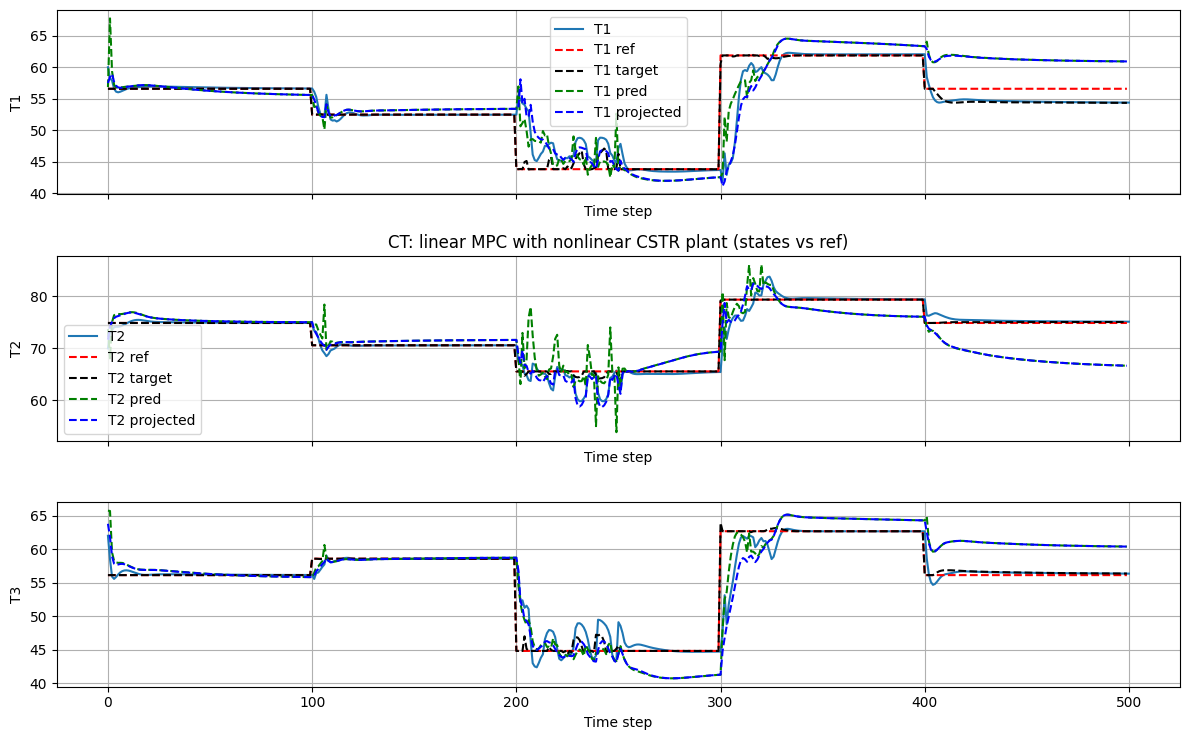

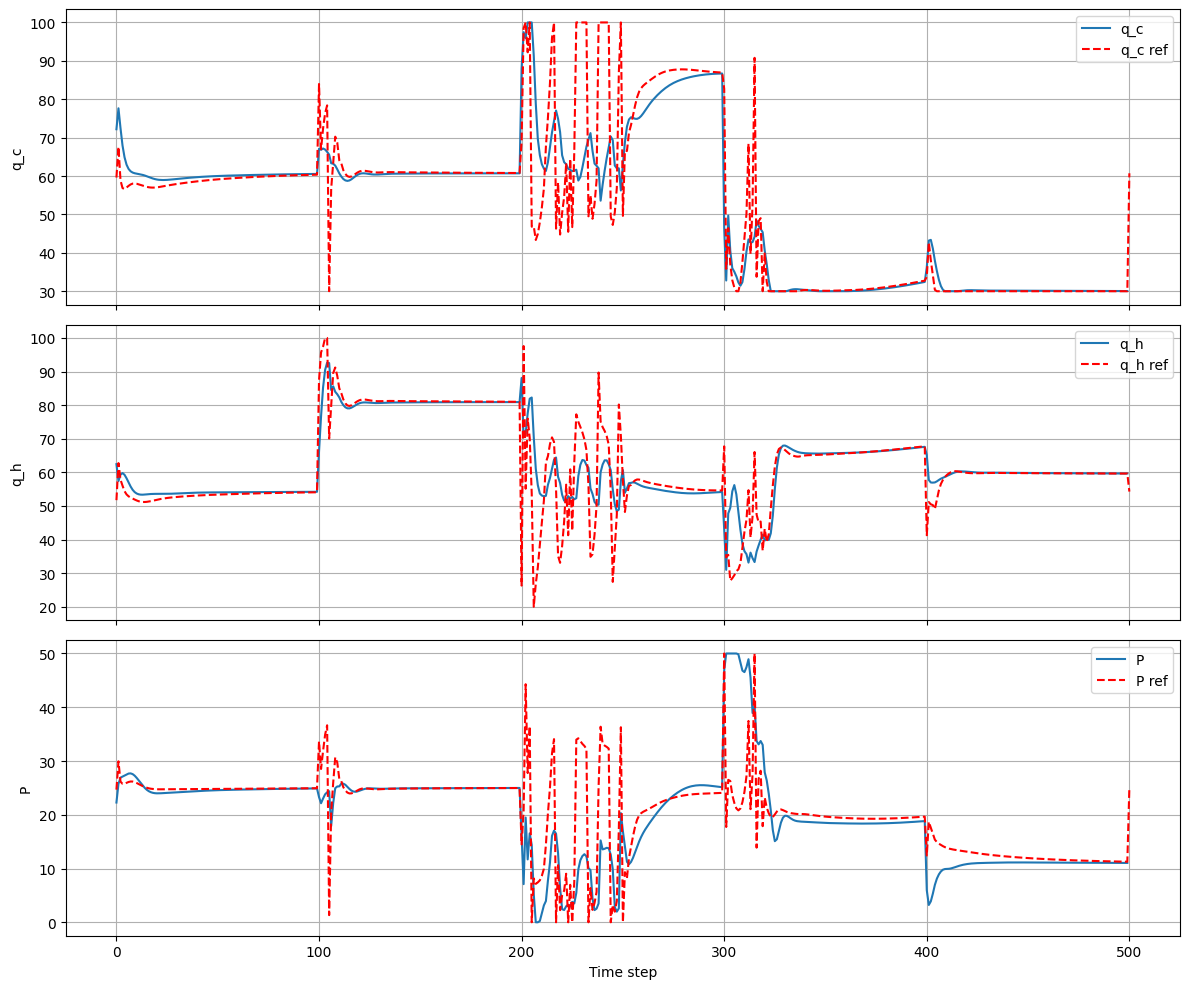

In [ ]:
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    y_ref_k = reference[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
names = ['T1', 'T2', 'T3']
n_steps = sim_time
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
us_sim_ns = scalerU.inverse_transform(us_sim.T).T
y_pred_ns = scaler.inverse_transform(y_pred.T).T
y_projected = get_y_vector(T_real @ z_sim[:nz,:])
y_projected_ns = scaler.inverse_transform(y_projected).T

fig, axs = plt.subplots(min(8, ny), 1, figsize=(12, 2.5*min(8, ny)), sharex=True)
if min(8, ny) == 1:
    axs = [axs]  # ensure axs is iterable even for 1 plot

for i in range(min(8, ny)):
    ax = axs[i]
    ax.plot(y_sim_descaled[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
        ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    ax.plot(y_pred_ns[i, :n_steps], 'g--', label=f'{names[i]} pred')
    ax.plot(y_projected_ns[i, :n_steps], 'b--', label=f'{names[i]} projected')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0, 1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'q_h', 'P']
for i in range(3):
    axs[i].plot(u_sim_descaled[i, :], label=input_names[i])
    axs[i].plot(us_sim_ns[i, :], 'r--', label=f"{input_names[i]} ref")
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#412
#627
#398
#846
#438

In [ ]:
sum(u_sim_descaled[2,:])

np.float64(9906.66627562023)

In [ ]:
sum(sum(z_sim[nz:,:]))

np.float64(-19.82074216321598)

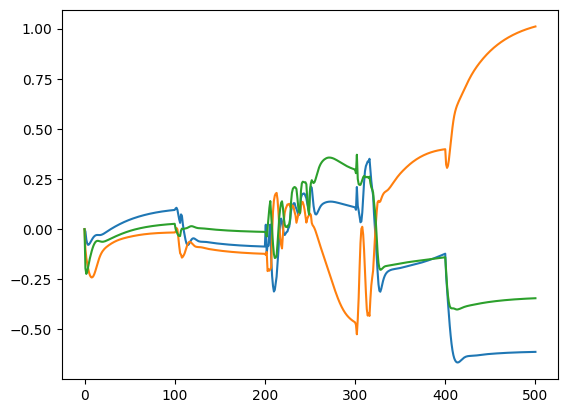

In [ ]:
plt.plot(z_sim[nz:,:].T)

In [ ]:
z_sim[nz:,-1]

array([-0.61178933,  1.01070191, -0.34431155])

In [ ]:
ys_sim_ns[:,-2]

array([54.34539136, 75.0775901 , 56.36984762])

In [17]:
# Closed-loop example using Python controller functions from `experiments/controllers_T2D2.py`

import importlib
from pathlib import Path

# Ensure `pausterization_unit/experiments` is on sys.path so we can import controllers_T2D2
project_root = Path.cwd().resolve().parent  # this notebook lives in pausterization_unit/control_sim
experiments_path = project_root / "experiments"
if str(experiments_path) not in sys.path:
    sys.path.append(str(experiments_path))

controllers_T2D2 = importlib.import_module("controllers_T2D2")

# Initialize Koopman-based controller (loads A, B, C, scalers, EKF, MPC, etc.)
controllers_T2D2.load()
controllers_T2D2.tests()  # optional sanity check, runs one MPC solve


Close to block diagonal? True
Backtransformation equals original A? True
[-0.47613739 -0.60641529  0.17223905  0.70043979  0.09572823 -0.03067617
 -0.4901682  -0.3564689   0.22814595 -0.15779608 -0.74991719 -1.53755421
 -1.13185666 -1.34763185 -0.69600192 -1.00098576 -0.57889597 -1.47828818
 -0.44983588 -0.62150763 -0.51771626 -0.61561761 -0.79917472  0.63377094
  0.70109248 -0.23210389 -3.01775279 -0.1765855  -0.78057969]


In [18]:
controllers_T2D2.next_optimal_input(np.array([70.0, 90.0, 30.0]),np.array([53.35294, 49.48008, 52.59292]), 1)

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


(array([56.58062742, 74.89001508, 56.13716923]),
 array([85.53918853, 76.32320169, 37.2953365 ]),
 array([88.08385335, 91.07292247, 37.45615575]))

In [19]:

# -----------------------------
# Closed-loop simulation via controllers_T2D2.next_optimal_input
# -----------------------------

sim_time = controllers_T2D2.loaded_setup["sim_time"]

ny = controllers_T2D2.C.shape[0]
nu = controllers_T2D2.B.shape[1]

# Storage
y_sim_ctrl = np.zeros((ny, sim_time + 1))
u_sim_ctrl = np.zeros((nu, sim_time))

# Initial conditions from controller module
y_sim_ctrl[:, 0] = controllers_T2D2.y_start.flatten()
u_prev = controllers_T2D2.u_previous.flatten()

from tqdm import trange
for k in trange(sim_time, desc="Closed-loop sim"):
    # Nonlinear plant step (baseline_inference is already initialized in earlier cells)
    y_meas = baseline_inference.y_plus(u_prev)
    y_sim_ctrl[:, k + 1] = y_meas.flatten()
    y_meas = scaler.inverse_transform(y_meas.reshape(1, -1))[0]
    # print(y_meas)
    # print(scalerU.inverse_transform(u_prev.reshape(1, -1))[0])

    # Compute next optimal input and steady-state target using the Python controller API
    y_s, u_opt, u_s = controllers_T2D2.next_optimal_input(scalerU.inverse_transform(u_prev.reshape(1, -1)).flatten(), y_meas.flatten(), k+1)

    u_sim_ctrl[:, k] = scalerU.transform(u_opt.reshape(1, -1))[0]
    u_prev = scalerU.transform(u_opt.reshape(1, -1))[0]

# Simple visualization of outputs and inputs
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(y_sim_ctrl.T)
axs[0].set_ylabel("Outputs y")
axs[0].grid(True)

axs[1].plot(u_sim_ctrl.T)
axs[1].set_ylabel("Inputs u")
axs[1].set_xlabel("Time step")
axs[1].grid(True)

plt.tight_layout()


Closed-loop sim:   0%|          | 0/500 [00:00<?, ?it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.328556 73.11966  54.1652  ]
[70. 90. 30.]


Closed-loop sim:   0%|          | 1/500 [00:00<04:29,  1.85it/s]

[54.212677 71.9886   53.822624]
[83.22280996 77.70724364 31.09773804]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:   0%|          | 2/500 [00:01<05:05,  1.63it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.886158 71.97527  53.580795]
[84.30091687 76.92393127 26.3852725 ]


Closed-loop sim:   1%|          | 3/500 [00:01<04:19,  1.91it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.84854 71.40011 54.3669 ]
[84.19166775 78.78348782 23.57929964]


Closed-loop sim:   1%|          | 4/500 [00:02<03:57,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.137794 71.3826   54.531345]
[84.73469157 80.39379202 21.96554408]


Closed-loop sim:   1%|          | 5/500 [00:02<04:05,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.3636   71.00737  54.676064]
[85.36011422 81.34460935 20.79369673]


Closed-loop sim:   1%|          | 6/500 [00:02<03:46,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.590027 70.74925  54.806946]
[85.56191915 81.43819933 19.96187629]


Closed-loop sim:   1%|▏         | 7/500 [00:03<03:34,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.72811 70.585   54.77155]
[85.37105678 80.96470051 19.32141592]


Closed-loop sim:   2%|▏         | 8/500 [00:03<03:26,  2.38it/s]

[55.81666 70.48956 54.74341]
[84.86270019 80.24294515 18.82018223]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:   2%|▏         | 9/500 [00:04<03:44,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.88599  70.40167  54.731506]
[84.12248845 79.4140982  18.4137009 ]


Closed-loop sim:   2%|▏         | 10/500 [00:04<03:34,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.938972 70.31355  54.699764]
[83.23448174 78.53269427 18.07275099]


Closed-loop sim:   2%|▏         | 11/500 [00:05<03:27,  2.36it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.986332 70.23323  54.649166]
[82.27158863 77.65145142 17.78760901]


Closed-loop sim:   2%|▏         | 12/500 [00:05<03:40,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.017994 70.15779  54.580265]
[81.29857608 76.81463039 17.54774777]


Closed-loop sim:   3%|▎         | 13/500 [00:05<03:30,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.03474 70.08015 54.50672]
[80.36266419 76.05926464 17.34075523]


Closed-loop sim:   3%|▎         | 14/500 [00:06<03:23,  2.39it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.037018 70.00406  54.439796]
[79.498606   75.40482794 17.15811471]


Closed-loop sim:   3%|▎         | 15/500 [00:06<03:39,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.02468  69.926445 54.377335]
[78.72518644 74.85621015 16.99129565]


Closed-loop sim:   3%|▎         | 16/500 [00:07<03:29,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.99874  69.84582  54.317894]
[78.04863895 74.41260001 16.83474796]


Closed-loop sim:   3%|▎         | 17/500 [00:07<03:22,  2.38it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.962772 69.76264  54.262676]
[77.46748714 74.06962299 16.68541673]


Closed-loop sim:   4%|▎         | 18/500 [00:08<03:19,  2.41it/s]

[55.920113 69.67645  54.21257 ]
[76.97598722 73.81934758 16.54035296]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:   4%|▍         | 19/500 [00:08<03:36,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.873837 69.58733  54.168037]
[76.56728521 73.65154405 16.39907045]


Closed-loop sim:   4%|▍         | 20/500 [00:08<03:27,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.825188 69.49541  54.128162]
[76.23296101 73.55528601 16.26062666]


Closed-loop sim:   4%|▍         | 21/500 [00:09<03:38,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.77505  69.400856 54.09229 ]
[75.96381741 73.51978347 16.12488544]


Closed-loop sim:   4%|▍         | 22/500 [00:10<03:48,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.72418  69.30401  54.060173]
[75.75037775 73.53518096 15.99196462]


Closed-loop sim:   5%|▍         | 23/500 [00:10<03:35,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.673267 69.205215 54.031727]
[75.58382966 73.59236573 15.86290573]


Closed-loop sim:   5%|▍         | 24/500 [00:10<03:26,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.62268 69.10484 54.00666]
[75.45535267 73.68331    15.73789803]


Closed-loop sim:   5%|▌         | 25/500 [00:11<03:19,  2.38it/s]

[55.57295 69.0034  53.9845 ]
[75.35735998 73.80041919 15.61852024]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:   5%|▌         | 26/500 [00:11<03:33,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.52457  68.9014   53.964817]
[75.28339346 73.93712654 15.50641396]


Closed-loop sim:   5%|▌         | 27/500 [00:12<03:30,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.47783 68.7992  53.9475 ]
[75.22827138 74.08784123 15.40269087]


Closed-loop sim:   6%|▌         | 28/500 [00:12<03:21,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.432766 68.697136 53.93235 ]
[75.18784345 74.24783497 15.30778872]


Closed-loop sim:   6%|▌         | 29/500 [00:13<03:32,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.389282 68.59548  53.919167]
[75.15870974 74.41327132 15.22175339]


Closed-loop sim:   6%|▌         | 30/500 [00:13<03:22,  2.32it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.34722  68.494484 53.90768 ]
[75.13794124 74.58112724 15.14437007]


Closed-loop sim:   6%|▌         | 31/500 [00:13<03:16,  2.39it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.306465 68.3943   53.89764 ]
[75.12301285 74.74907753 15.07552189]


Closed-loop sim:   6%|▋         | 32/500 [00:14<03:30,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.266903 68.29511  53.888885]
[75.11181479 74.91530608 15.01519458]


Closed-loop sim:   7%|▋         | 33/500 [00:14<03:20,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.228413 68.197044 53.881325]
[75.10260082 75.0783562  14.9633162 ]


Closed-loop sim:   7%|▋         | 34/500 [00:15<03:13,  2.41it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.190823 68.10022  53.87481 ]
[75.09393072 75.23702582 14.91975105]


Closed-loop sim:   7%|▋         | 35/500 [00:15<03:09,  2.45it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.154003 68.00478  53.86917 ]
[75.08461751 75.39034453 14.88432459]


Closed-loop sim:   7%|▋         | 36/500 [00:15<03:23,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.117844 67.91094  53.864254]
[75.07371434 75.53756934 14.85682443]


Closed-loop sim:   7%|▋         | 37/500 [00:16<03:15,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.082233 67.81885  53.85997 ]
[75.06048848 75.6781747  14.83696384]


Closed-loop sim:   8%|▊         | 38/500 [00:16<03:10,  2.42it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.04698  67.72868  53.856194]
[75.04442159 75.81178539 14.82444533]


Closed-loop sim:   8%|▊         | 39/500 [00:17<03:24,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.01196  67.64053  53.852818]
[75.02514528 75.93818066 14.81898312]


Closed-loop sim:   8%|▊         | 40/500 [00:17<03:16,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.977047 67.55448  53.84975 ]
[75.00240356 76.05726782 14.82029788]


Closed-loop sim:   8%|▊         | 41/500 [00:18<03:10,  2.41it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.942146 67.47058  53.846912]
[74.97604113 76.16904416 14.82810933]


Closed-loop sim:   8%|▊         | 42/500 [00:18<03:32,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.907196 67.388885 53.844193]
[74.94599166 76.27357411 14.84214032]


Closed-loop sim:   9%|▊         | 43/500 [00:19<03:22,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.87209 67.30946 53.84151]
[74.91229164 76.37099337 14.86210647]


Closed-loop sim:   9%|▉         | 44/500 [00:19<03:15,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.83671  67.23232  53.838818]
[74.87504506 76.46150276 14.88771769]


Closed-loop sim:   9%|▉         | 45/500 [00:19<03:09,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.80097  67.157524 53.83614 ]
[74.83438379 76.54534356 14.918705  ]


Closed-loop sim:   9%|▉         | 46/500 [00:20<03:23,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.764782 67.08508  53.833454]
[74.79045891 76.62274909 14.9548062 ]


Closed-loop sim:   9%|▉         | 47/500 [00:20<03:14,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.7281   67.01499  53.830723]
[74.74345177 76.69394428 14.99578106]


Closed-loop sim:  10%|▉         | 48/500 [00:21<03:08,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.690865 66.94726  53.82792 ]
[74.69355073 76.75915805 15.04139777]


Closed-loop sim:  10%|▉         | 49/500 [00:21<03:23,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.653027 66.88185  53.82501 ]
[74.64094015 76.8186162  15.09142873]


Closed-loop sim:  10%|█         | 50/500 [00:22<03:14,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.61454  66.81878  53.821964]
[74.58579695 76.87254323 15.1456615 ]


Closed-loop sim:  10%|█         | 51/500 [00:22<03:08,  2.38it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.575356 66.758026 53.818764]
[74.52828823 76.92115809 15.20389293]


Closed-loop sim:  10%|█         | 52/500 [00:22<03:06,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.535442 66.69956  53.815388]
[74.46856684 76.96467209 15.26593121]


Closed-loop sim:  11%|█         | 53/500 [00:23<03:20,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.494797 66.64337  53.811806]
[74.40677727 77.00328474 15.33160037]


Closed-loop sim:  11%|█         | 54/500 [00:23<03:12,  2.32it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.45338  66.589424 53.808014]
[74.34307113 77.03719107 15.40072591]


Closed-loop sim:  11%|█         | 55/500 [00:24<03:06,  2.39it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.41117  66.5377   53.803993]
[74.27758613 77.06657757 15.47314715]


Closed-loop sim:  11%|█         | 56/500 [00:24<03:20,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.36814  66.488174 53.799744]
[74.21044857 77.09162403 15.54871261]


Closed-loop sim:  11%|█▏        | 57/500 [00:25<03:13,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.32427 66.44084 53.79525]
[74.14176854 77.11249879 15.62727985]


Closed-loop sim:  12%|█▏        | 58/500 [00:25<03:11,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.279533 66.39574  53.7905  ]
[74.07163347 77.12935592 15.70871418]


Closed-loop sim:  12%|█▏        | 59/500 [00:25<03:22,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.23391  66.35284  53.785435]
[74.00011622 77.14231795 15.79287367]


Closed-loop sim:  12%|█▏        | 60/500 [00:26<03:30,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.187378 66.31214  53.780045]
[73.9272802  77.15151485 15.87962993]


Closed-loop sim:  12%|█▏        | 61/500 [00:26<03:18,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.139935 66.273605 53.774323]
[73.85317949 77.15708188 15.96886146]


Closed-loop sim:  12%|█▏        | 62/500 [00:27<03:10,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.091488 66.23719  53.768257]
[73.77786608 77.15915314 16.06046443]


Closed-loop sim:  13%|█▎        | 63/500 [00:27<03:21,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.041954 66.20287  53.761837]
[73.70134997 77.1578747  16.15437313]


Closed-loop sim:  13%|█▎        | 64/500 [00:28<03:11,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.99131  66.17063  53.755074]
[73.62360231 77.15339072 16.25056018]


Closed-loop sim:  13%|█▎        | 65/500 [00:28<03:05,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.939545 66.140495 53.748   ]
[73.54458956 77.14581285 16.3490114 ]


Closed-loop sim:  13%|█▎        | 66/500 [00:29<03:03,  2.36it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.886703 66.11245  53.74067 ]
[73.46427923 77.13520499 16.44969565]


Closed-loop sim:  13%|█▎        | 67/500 [00:29<03:53,  1.85it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.83276  66.086494 53.73308 ]
[73.38265446 77.12157695 16.5525614 ]


Closed-loop sim:  14%|█▎        | 68/500 [00:30<03:36,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.777687 66.0626   53.725227]
[73.29967971 77.10493922 16.65755498]


Closed-loop sim:  14%|█▍        | 69/500 [00:30<03:22,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.72147 66.04075 53.7171 ]
[73.21530195 77.08531976 16.76464158]


Closed-loop sim:  14%|█▍        | 70/500 [00:31<03:37,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.664085 66.02092  53.70868 ]
[73.12946176 77.06275906 16.87380135]


Closed-loop sim:  14%|█▍        | 71/500 [00:31<03:22,  2.12it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.605503 66.003105 53.699978]
[73.04210554 77.03730351 16.98502417]


Closed-loop sim:  14%|█▍        | 72/500 [00:32<03:11,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.545692 65.987335 53.69101 ]
[72.95317597 77.00899578 17.09830881]


Closed-loop sim:  15%|█▍        | 73/500 [00:32<03:03,  2.32it/s]

[53.48463 65.97363 53.68181]
[72.86260896 76.97786638 17.21364921]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  15%|█▍        | 74/500 [00:32<03:14,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.42239  65.96199  53.672405]
[72.77032289 76.94392844 17.33103708]


Closed-loop sim:  15%|█▌        | 75/500 [00:33<03:05,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.35908  65.95238  53.662823]
[72.67626938 76.90719797 17.4504488 ]


Closed-loop sim:  15%|█▌        | 76/500 [00:33<02:59,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.29468  65.9448   53.653057]
[72.58046259 76.86767538 17.57183087]


Closed-loop sim:  15%|█▌        | 77/500 [00:34<03:11,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.229168 65.939255 53.643112]
[72.48291283 76.82539303 17.69512853]


Closed-loop sim:  16%|█▌        | 78/500 [00:34<03:04,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.16253  65.935745 53.632996]
[72.3836124  76.78040216 17.82030221]


Closed-loop sim:  16%|█▌        | 79/500 [00:35<02:58,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.094852 65.93434  53.62275 ]
[72.28253606 76.73275974 17.94732676]


Closed-loop sim:  16%|█▌        | 80/500 [00:35<03:10,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.02615 65.93507 53.61239]
[72.17968596 76.68248325 18.07613968]


Closed-loop sim:  16%|█▌        | 81/500 [00:35<03:02,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.95642  65.93792  53.601917]
[72.07506151 76.62958875 18.2066694 ]


Closed-loop sim:  16%|█▋        | 82/500 [00:36<02:58,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.885643 65.94291  53.591343]
[71.96864464 76.57410535 18.33885741]


Closed-loop sim:  17%|█▋        | 83/500 [00:36<03:04,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.81379  65.95004  53.580666]
[71.86044009 76.51605474 18.47269484]


Closed-loop sim:  17%|█▋        | 84/500 [00:37<03:17,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.740837 65.95936  53.56989 ]
[71.75039101 76.455472   18.60814821]


Closed-loop sim:  17%|█▋        | 85/500 [00:37<03:08,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.666763 65.97086  53.55905 ]
[71.63838482 76.39239844 18.74517485]


Closed-loop sim:  17%|█▋        | 86/500 [00:38<03:04,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.591755 65.98451  53.54814 ]
[71.52428546 76.32683839 18.88375623]


Closed-loop sim:  17%|█▋        | 87/500 [00:38<03:13,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.51591  66.000275 53.537148]
[71.40805068 76.25876674 19.0238588 ]


Closed-loop sim:  18%|█▊        | 88/500 [00:39<03:04,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.439213 66.01817  53.526066]
[71.28971213 76.18818069 19.16542917]


Closed-loop sim:  18%|█▊        | 89/500 [00:39<02:57,  2.32it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.361618 66.03824  53.5149  ]
[71.16930061 76.11513434 19.308417  ]


Closed-loop sim:  18%|█▊        | 90/500 [00:39<02:52,  2.38it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.283226 66.0602   53.503765]
[71.04681414 76.03972282 19.45278666]


Closed-loop sim:  18%|█▊        | 91/500 [00:40<03:09,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.204063 66.084045 53.492683]
[70.92224894 75.96196103 19.59857509]


Closed-loop sim:  18%|█▊        | 92/500 [00:40<03:00,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.124172 66.109764 53.481644]
[70.79557923 75.88182417 19.74583794]


Closed-loop sim:  19%|█▊        | 93/500 [00:41<02:54,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.04357  66.13735  53.470642]
[70.66678383 75.79927936 19.89460014]


Closed-loop sim:  19%|█▉        | 94/500 [00:41<03:19,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.962254 66.16684  53.459675]
[70.53583856 75.71431174 20.04486135]


Closed-loop sim:  19%|█▉        | 95/500 [00:42<03:20,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.880203 66.19824  53.448742]
[70.40270903 75.62693198 20.19661705]


Closed-loop sim:  19%|█▉        | 96/500 [00:42<03:23,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.79741 66.2316  53.43786]
[70.26733118 75.53716153 20.34987767]


Closed-loop sim:  19%|█▉        | 97/500 [00:43<03:09,  2.12it/s]

[51.713856 66.26693  53.42703 ]
[70.12962213 75.44501613 20.50466193]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  20%|█▉        | 98/500 [00:43<03:17,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.629547 66.30425  53.41626 ]
[69.98948916 75.35051133 20.66100068]


Closed-loop sim:  20%|█▉        | 99/500 [00:44<03:04,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.54447  66.343605 53.40556 ]
[69.84684461 75.25366054 20.81893292]


Closed-loop sim:  20%|██        | 100/500 [00:44<02:59,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.74983 64.93544 53.25113]
[73.11681989 74.7361817  15.27652128]


Closed-loop sim:  20%|██        | 101/500 [00:45<03:12,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.00864  64.37289  52.964905]
[75.90840542 75.88612745 12.88378046]


Closed-loop sim:  20%|██        | 102/500 [00:45<03:04,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.24334 64.31132 52.87103]
[77.81977564 78.11632158 11.71494634]


Closed-loop sim:  21%|██        | 103/500 [00:46<02:57,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.360897 64.31162  52.8673  ]
[79.36498882 80.39103798 11.0172161 ]


Closed-loop sim:  21%|██        | 104/500 [00:46<03:09,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.423595 64.34202  52.86203 ]
[80.75380888 82.32379075 10.47834432]


Closed-loop sim:  21%|██        | 105/500 [00:47<03:04,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.436245 64.34323  52.84795 ]
[82.00158208 83.89800907  9.98225722]


Closed-loop sim:  21%|██        | 106/500 [00:47<03:34,  1.83it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.435993 64.32031  52.833557]
[83.0824265  85.21467307  9.51904019]


Closed-loop sim:  21%|██▏       | 107/500 [00:48<03:23,  1.93it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.439793 64.27887  52.82552 ]
[83.99114111 86.35689175  9.101136  ]


Closed-loop sim:  22%|██▏       | 108/500 [00:48<03:31,  1.85it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.44229  64.2236   52.814823]
[84.74436895 87.36877901  8.73578222]


Closed-loop sim:  22%|██▏       | 109/500 [00:49<03:21,  1.94it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.44266  64.16269  52.804295]
[85.36369058 88.27645597  8.42529956]


Closed-loop sim:  22%|██▏       | 110/500 [00:49<03:20,  1.95it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.440483 64.09784  52.79472 ]
[85.87063779 89.09469007  8.16620655]


Closed-loop sim:  22%|██▏       | 111/500 [00:50<03:42,  1.75it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.43516  64.029335 52.78702 ]
[86.28428357 89.83347024  7.95283563]


Closed-loop sim:  22%|██▏       | 112/500 [00:50<03:31,  1.84it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.42639  63.95791  52.780354]
[86.62046985 90.50137826  7.77940592]


Closed-loop sim:  23%|██▎       | 113/500 [00:51<03:18,  1.95it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.41405  63.884655 52.773857]
[86.89202562 91.10668377  7.64090023]


Closed-loop sim:  23%|██▎       | 114/500 [00:51<03:11,  2.01it/s]

[53.398182 63.810402 52.76708 ]
[87.10931655 91.657286    7.53303417]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  23%|██▎       | 115/500 [00:52<03:18,  1.94it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.37904  63.735863 52.760216]
[87.2809405  92.16032542  7.45216962]


Closed-loop sim:  23%|██▎       | 116/500 [00:52<03:14,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.357018 63.661514 52.753433]
[87.41424624 92.62184704  7.39506533]


Closed-loop sim:  23%|██▎       | 117/500 [00:53<03:11,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.33238  63.587715 52.746674]
[87.51557789 93.04684642  7.35877305]


Closed-loop sim:  24%|██▎       | 118/500 [00:54<03:34,  1.78it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.305275 63.514736 52.739777]
[87.59033826 93.43955753  7.34064701]


Closed-loop sim:  24%|██▍       | 119/500 [00:54<03:21,  1.89it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.27588  63.442795 52.732677]
[87.64306522 93.80368146  7.33837262]


Closed-loop sim:  24%|██▍       | 120/500 [00:55<03:10,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.24438  63.372066 52.725372]
[87.67757909 94.14244403  7.3499343 ]


Closed-loop sim:  24%|██▍       | 121/500 [00:55<03:18,  1.91it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.210968 63.30267  52.717857]
[87.6971183  94.45861828  7.37356413]


Closed-loop sim:  24%|██▍       | 122/500 [00:56<03:07,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.175797 63.23468  52.71011 ]
[87.70443379 94.75457768  7.40770456]


Closed-loop sim:  25%|██▍       | 123/500 [00:56<03:00,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.139015 63.168163 52.702103]
[87.70185134 95.03237259  7.45099079]


Closed-loop sim:  25%|██▍       | 124/500 [00:57<03:09,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.10075  63.103146 52.69383 ]
[87.69133194 95.29377745  7.5022201 ]


Closed-loop sim:  25%|██▌       | 125/500 [00:57<03:34,  1.75it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.06112  63.03967  52.685272]
[87.67438472 95.54051782  7.56033588]


Closed-loop sim:  25%|██▌       | 126/500 [00:58<03:20,  1.87it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.020107 62.978058 52.676357]
[87.65223313 95.77418445  7.62452226]


Closed-loop sim:  25%|██▌       | 127/500 [00:58<03:10,  1.96it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.977795 62.918392 52.667072]
[87.62589071 95.99613073  7.69405765]


Closed-loop sim:  26%|██▌       | 128/500 [00:59<03:23,  1.83it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.934574 62.86059  52.657486]
[87.59623591 96.2074592   7.7683001 ]


Closed-loop sim:  26%|██▌       | 129/500 [00:59<03:16,  1.88it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.890648 62.804596 52.64761 ]
[87.5641112  96.40895043  7.84662957]


Closed-loop sim:  26%|██▌       | 130/500 [01:00<03:09,  1.95it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.846096 62.750355 52.637444]
[87.53024976 96.60122038  7.92845   ]


Closed-loop sim:  26%|██▌       | 131/500 [01:00<03:00,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.801003 62.697796 52.626995]
[87.49526104 96.78482325  8.01323766]


Closed-loop sim:  26%|██▋       | 132/500 [01:01<03:09,  1.94it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.755436 62.64686  52.61627 ]
[87.45963965 96.9602917   8.10055748]


Closed-loop sim:  27%|██▋       | 133/500 [01:01<03:01,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.709476 62.59747  52.605278]
[87.42379103 97.12811834  8.19003849]


Closed-loop sim:  27%|██▋       | 134/500 [01:02<02:56,  2.07it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.663174 62.54956  52.59403 ]
[87.3880539  97.28874036  8.28134713]


Closed-loop sim:  27%|██▋       | 135/500 [01:02<03:05,  1.97it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.61659  62.503067 52.58253 ]
[87.35270407 97.44255265  8.37418502]


Closed-loop sim:  27%|██▋       | 136/500 [01:03<02:58,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.569775 62.45793  52.57078 ]
[87.31797113 97.58990895  8.46828115]


Closed-loop sim:  27%|██▋       | 137/500 [01:03<02:53,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.522774 62.41414  52.558758]
[87.28403808 97.73112952  8.56338972]


Closed-loop sim:  28%|██▊       | 138/500 [01:04<02:48,  2.15it/s]

[52.47563  62.371643 52.54645 ]
[87.25104363 97.86651278  8.65928441]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  28%|██▊       | 139/500 [01:04<02:59,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.428383 62.33038  52.53388 ]
[87.21908991 97.99633799  8.75575791]


Closed-loop sim:  28%|██▊       | 140/500 [01:05<02:52,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.381058 62.290287 52.521046]
[87.18826281 98.12085993  8.85263411]


Closed-loop sim:  28%|██▊       | 141/500 [01:05<02:47,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.33367  62.251278 52.50794 ]
[87.15863549 98.24030442  8.94976192]


Closed-loop sim:  28%|██▊       | 142/500 [01:06<02:58,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.286083 62.21325  52.494526]
[87.13025736 98.35490015  9.04702592]


Closed-loop sim:  29%|██▊       | 143/500 [01:06<02:52,  2.07it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.23824  62.17614  52.480816]
[87.10312448 98.46493984  9.14438217]


Closed-loop sim:  29%|██▉       | 144/500 [01:07<02:56,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.190174 62.139915 52.46683 ]
[87.07721815 98.57071654  9.24182775]


Closed-loop sim:  29%|██▉       | 145/500 [01:07<03:05,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.141922 62.10454  52.45259 ]
[87.05253906 98.67245985  9.33935475]


Closed-loop sim:  29%|██▉       | 146/500 [01:08<02:55,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.093506 62.069984 52.43811 ]
[87.02909897 98.7703428   9.43693536]


Closed-loop sim:  29%|██▉       | 147/500 [01:08<02:50,  2.07it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.04495  62.036217 52.4234  ]
[87.00690957 98.86450744  9.53453066]


Closed-loop sim:  30%|██▉       | 148/500 [01:08<02:46,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.99627  62.0032   52.408474]
[86.98597535 98.95507502  9.63208533]


Closed-loop sim:  30%|██▉       | 149/500 [01:09<02:57,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.947475 61.970932 52.39335 ]
[86.96628997 99.04216367  9.72954502]


Closed-loop sim:  30%|███       | 150/500 [01:10<02:51,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.898594 61.93936  52.378033]
[86.94783765 99.12589017  9.82685031]


Closed-loop sim:  30%|███       | 151/500 [01:10<02:49,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.849644 61.908478 52.362522]
[86.93059509 99.20637096  9.92395047]


Closed-loop sim:  30%|███       | 152/500 [01:11<03:01,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.800648 61.878242 52.346836]
[86.91452182 99.28373483 10.02080859]


Closed-loop sim:  31%|███       | 153/500 [01:11<02:54,  1.99it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.751617 61.84864  52.330982]
[86.89958695 99.35810987 10.11739685]


Closed-loop sim:  31%|███       | 154/500 [01:12<02:49,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.702576 61.819645 52.31497 ]
[86.88577191 99.42958778 10.21369653]


Closed-loop sim:  31%|███       | 155/500 [01:12<02:45,  2.08it/s]

[51.65349 61.79124 52.29878]
[86.87301857 99.49827953 10.30966137]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  31%|███       | 156/500 [01:13<02:56,  1.95it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.604233 61.76338  52.282345]
[86.86127028 99.56431926 10.4052609 ]


Closed-loop sim:  31%|███▏      | 157/500 [01:13<02:49,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.55482 61.73605 52.26568]
[86.85043742 99.62789083 10.50052544]


Closed-loop sim:  32%|███▏      | 158/500 [01:14<02:49,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.50539  61.709198 52.24878 ]
[86.84044557 99.68914682 10.59549813]


Closed-loop sim:  32%|███▏      | 159/500 [01:14<03:05,  1.83it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.456047 61.68278  52.231636]
[86.83128517 99.74816535 10.69019717]


Closed-loop sim:  32%|███▏      | 160/500 [01:15<02:57,  1.91it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.406788 61.656784 52.214264]
[86.82295475 99.80495835 10.7846167 ]


Closed-loop sim:  32%|███▏      | 161/500 [01:15<03:01,  1.87it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.357643 61.63116  52.196625]
[86.81544676 99.85954384 10.87873069]


Closed-loop sim:  32%|███▏      | 162/500 [01:16<03:53,  1.45it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.30864  61.605896 52.178734]
[86.80871043 99.91194003 10.97253256]


Closed-loop sim:  33%|███▎      | 163/500 [01:17<03:27,  1.62it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.259747 61.581    52.16061 ]
[86.80239782 99.96193374 11.06610308]


Closed-loop sim:  33%|███▎      | 164/500 [01:17<03:11,  1.76it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.2093   61.556458 52.14159 ]
[86.78347971 99.99664056 11.16211555]


Closed-loop sim:  33%|███▎      | 165/500 [01:18<02:58,  1.87it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.156387 61.53191  52.120792]
[ 86.74820161 100.          11.25808673]


Closed-loop sim:  33%|███▎      | 166/500 [01:18<03:00,  1.85it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.102654 61.50844  52.099926]
[ 86.70288835 100.          11.35694764]


Closed-loop sim:  33%|███▎      | 167/500 [01:19<02:49,  1.97it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.04881  61.48612  52.079437]
[ 86.6528035  100.          11.45909807]


Closed-loop sim:  34%|███▎      | 168/500 [01:19<02:43,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.994637 61.464767 52.059055]
[ 86.60207039 100.          11.56355864]


Closed-loop sim:  34%|███▍      | 169/500 [01:20<02:50,  1.95it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.940414 61.444054 52.038654]
[ 86.55316878 100.          11.6692162 ]


Closed-loop sim:  34%|███▍      | 170/500 [01:20<02:41,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.886356 61.423904 52.018215]
[ 86.50739463 100.          11.77517005]


Closed-loop sim:  34%|███▍      | 171/500 [01:20<02:35,  2.12it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.832603 61.40421  51.99772 ]
[ 86.46529755 100.          11.88072816]


Closed-loop sim:  34%|███▍      | 172/500 [01:21<02:31,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.77929  61.384872 51.97719 ]
[ 86.42695046 100.          11.98543126]


Closed-loop sim:  35%|███▍      | 173/500 [01:22<03:00,  1.82it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.72651  61.365845 51.95661 ]
[ 86.39224247 100.          12.08898248]


Closed-loop sim:  35%|███▍      | 174/500 [01:22<02:50,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.67432  61.34708  51.936005]
[ 86.36104629 100.          12.19115595]


Closed-loop sim:  35%|███▌      | 175/500 [01:23<02:41,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.622757 61.328545 51.91538 ]
[ 86.33317361 100.          12.29181826]


Closed-loop sim:  35%|███▌      | 176/500 [01:23<03:19,  1.63it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.571842 61.310215 51.894745]
[ 86.30841484 100.          12.39090099]


Closed-loop sim:  35%|███▌      | 177/500 [01:24<03:02,  1.77it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.521576 61.292072 51.874107]
[ 86.28656286 100.          12.4883785 ]


Closed-loop sim:  36%|███▌      | 178/500 [01:24<02:51,  1.88it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.471962 61.274117 51.853477]
[ 86.26741895 100.          12.58425587]


Closed-loop sim:  36%|███▌      | 179/500 [01:25<02:42,  1.98it/s]

[50.423027 61.256336 51.832886]
[ 86.2507998 100.         12.6785507]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  36%|███▌      | 180/500 [01:25<02:56,  1.81it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.374744 61.238728 51.81232 ]
[ 86.23655454 100.          12.77128514]


Closed-loop sim:  36%|███▌      | 181/500 [01:26<02:45,  1.93it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.3271   61.221287 51.79178 ]
[ 86.22453582 100.          12.86249029]


Closed-loop sim:  36%|███▋      | 182/500 [01:26<02:38,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.280087 61.204014 51.77127 ]
[ 86.21459261 100.          12.95220433]


Closed-loop sim:  37%|███▋      | 183/500 [01:27<02:45,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.23369  61.1869   51.750797]
[ 86.20658287 100.          13.04046822]


Closed-loop sim:  37%|███▋      | 184/500 [01:27<02:36,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.187897 61.169945 51.730362]
[ 86.20037205 100.          13.12732793]


Closed-loop sim:  37%|███▋      | 185/500 [01:28<02:32,  2.06it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.142696 61.153145 51.709972]
[ 86.19584047 100.          13.21282846]


Closed-loop sim:  37%|███▋      | 186/500 [01:29<03:06,  1.68it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.09806  61.13649  51.689632]
[ 86.19287335 100.          13.2970147 ]


Closed-loop sim:  37%|███▋      | 187/500 [01:29<02:53,  1.80it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.05399  61.119984 51.66934 ]
[ 86.19135755 100.          13.3799364 ]


Closed-loop sim:  38%|███▊      | 188/500 [01:30<02:42,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.01053  61.10359  51.649082]
[ 86.19119153 100.          13.46163895]


Closed-loop sim:  38%|███▊      | 189/500 [01:30<02:35,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.9677  61.08728 51.62886]
[ 86.1923086  100.          13.54216545]


Closed-loop sim:  38%|███▊      | 190/500 [01:31<02:40,  1.93it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.925495 61.071064 51.608673]
[ 86.19466234 100.          13.62154788]


Closed-loop sim:  38%|███▊      | 191/500 [01:31<02:32,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.883907 61.05493  51.58852 ]
[ 86.19820204 100.          13.69981083]


Closed-loop sim:  38%|███▊      | 192/500 [01:31<02:26,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.842922 61.03888  51.5684  ]
[ 86.20287632 100.          13.77697615]


Closed-loop sim:  39%|███▊      | 193/500 [01:32<02:36,  1.96it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.80252  61.02291  51.548332]
[ 86.20862543 100.          13.85306707]


Closed-loop sim:  39%|███▉      | 194/500 [01:33<02:30,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.7627   61.007027 51.5283  ]
[ 86.21538451 100.          13.92810847]


Closed-loop sim:  39%|███▉      | 195/500 [01:33<02:28,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.723442 60.99122  51.508324]
[ 86.22308846 100.          14.00212249]


Closed-loop sim:  39%|███▉      | 196/500 [01:33<02:25,  2.08it/s]

[49.684734 60.975494 51.488396]
[ 86.23167244 100.          14.07513682]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  39%|███▉      | 197/500 [01:34<02:34,  1.96it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.64657  60.959854 51.46853 ]
[ 86.2410698  100.          14.14718005]


Closed-loop sim:  40%|███▉      | 198/500 [01:34<02:27,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.60892  60.944294 51.44872 ]
[ 86.25122183 100.          14.21827681]


Closed-loop sim:  40%|███▉      | 199/500 [01:35<02:23,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.57179  60.928814 51.428963]
[ 86.26206712 100.          14.28845711]


Closed-loop sim:  40%|████      | 200/500 [01:35<02:29,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.812286 58.613213 49.47227 ]
[88.74845599 80.31641882  2.11836504]


Closed-loop sim:  40%|████      | 201/500 [01:36<02:22,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.533566 57.900124 48.9296  ]
[8.17686678e+01 7.34490962e+01 4.22772928e-12]


Closed-loop sim:  40%|████      | 202/500 [01:36<02:16,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.79206  57.817104 48.80546 ]
[7.57590595e+01 7.15691952e+01 7.10542736e-14]


Closed-loop sim:  41%|████      | 203/500 [01:37<02:24,  2.06it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.943123 57.574627 48.941486]
[70.90422995 70.2511383   1.06929589]


Closed-loop sim:  41%|████      | 204/500 [01:37<02:17,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.161774 57.452866 49.169678]
[66.69961952 68.622722    2.94333422]


Closed-loop sim:  41%|████      | 205/500 [01:38<02:20,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.395218 57.432064 49.489132]
[63.24919731 66.336626    4.61059833]


Closed-loop sim:  41%|████      | 206/500 [01:38<02:13,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.569435 57.523167 49.76159 ]
[60.45952523 63.52744042  5.83348597]


Closed-loop sim:  41%|████▏     | 207/500 [01:39<02:20,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.692646 57.6695   49.95659 ]
[58.13507093 60.46830111  6.66578765]


Closed-loop sim:  42%|████▏     | 208/500 [01:39<02:15,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.780113 57.84628  50.03998 ]
[56.12127928 57.33308927  7.24392339]


Closed-loop sim:  42%|████▏     | 209/500 [01:40<02:10,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.85905  58.067596 50.030373]
[54.3365741  54.16048882  7.68323443]


Closed-loop sim:  42%|████▏     | 210/500 [01:40<02:19,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.939835 58.344757 49.94657 ]
[52.71806692 50.92846895  8.06050162]


Closed-loop sim:  42%|████▏     | 211/500 [01:41<02:12,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.02711 58.6827  49.81203]
[51.19945093 47.58822052  8.43131407]


Closed-loop sim:  42%|████▏     | 212/500 [01:41<02:06,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.149902 59.06482  49.64288 ]
[49.70731215 44.05266834  8.84912183]


Closed-loop sim:  43%|████▎     | 213/500 [01:41<02:02,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.37021  59.486214 49.50031 ]
[48.71466475 40.85915733  9.33743732]


Closed-loop sim:  43%|████▎     | 214/500 [01:42<02:09,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.68067  59.931652 49.39177 ]
[48.5579915  38.30669329  9.79652825]


Closed-loop sim:  43%|████▎     | 215/500 [01:42<02:04,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.03301  60.40537  49.261856]
[49.16886424 36.26967868 10.12795712]


Closed-loop sim:  43%|████▎     | 216/500 [01:43<02:00,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.364838 60.93694  49.082207]
[50.4607538  34.70071172 10.31171566]


Closed-loop sim:  43%|████▎     | 217/500 [01:43<02:08,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.556732 61.595055 48.86212 ]
[52.30841694 33.6143563  10.35618527]


Closed-loop sim:  44%|████▎     | 218/500 [01:44<02:02,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.549957 62.39392  48.57537 ]
[54.51598988 33.03957714 10.27831539]


Closed-loop sim:  44%|████▍     | 219/500 [01:44<01:58,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.31295  63.339787 48.16913 ]
[56.87334325 32.94647917 10.07151022]


Closed-loop sim:  44%|████▍     | 220/500 [01:44<01:54,  2.44it/s]

[50.848373 64.34127  47.680397]
[59.13951378 33.33381512  9.71838894]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  44%|████▍     | 221/500 [01:45<02:04,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.26363  65.199844 47.212826]
[61.09816921 34.20437066  9.23589575]


Closed-loop sim:  44%|████▍     | 222/500 [01:45<01:59,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.669117 65.86544  46.79917 ]
[62.63784007 35.45359321  8.69304782]


Closed-loop sim:  45%|████▍     | 223/500 [01:46<02:00,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.149494 66.29691  46.435844]
[63.74521388 36.92308912  8.15808715]


Closed-loop sim:  45%|████▍     | 224/500 [01:46<02:07,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.719074 66.54245  46.139225]
[64.48330159 38.46622985  7.68829571]


Closed-loop sim:  45%|████▌     | 225/500 [01:47<02:00,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.370644 66.6637   45.914883]
[64.92946774 39.97747026  7.31206948]


Closed-loop sim:  45%|████▌     | 226/500 [01:47<01:54,  2.38it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[48.091198 66.704666 45.75709 ]
[65.15146439 41.3909536   7.03157589]


Closed-loop sim:  45%|████▌     | 227/500 [01:48<02:03,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.869465 66.69519  45.654488]
[65.20315611 42.67210168  6.83435903]


Closed-loop sim:  46%|████▌     | 228/500 [01:48<01:57,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.695004 66.652664 45.595184]
[65.1259408  43.80950985  6.7038042 ]


Closed-loop sim:  46%|████▌     | 229/500 [01:48<01:53,  2.39it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.558758 66.58764  45.56832 ]
[64.95235133 44.80385452  6.6243759 ]


Closed-loop sim:  46%|████▌     | 230/500 [01:49<01:50,  2.45it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.45389  66.50624  45.565025]
[64.70766919 45.66276573  6.58249094]


Closed-loop sim:  46%|████▌     | 231/500 [01:49<01:58,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.374588 66.41272  45.578068]
[64.41146573 46.39832998  6.56727217]


Closed-loop sim:  46%|████▋     | 232/500 [01:50<01:53,  2.36it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.315838 66.31123  45.601646]
[64.0803442  47.02342411  6.57014774]


Closed-loop sim:  47%|████▋     | 233/500 [01:50<01:57,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.273182 66.2058   45.631042]
[63.72829318 47.5510595   6.58428188]


Closed-loop sim:  47%|████▋     | 234/500 [01:51<02:04,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.243244 66.0982   45.663143]
[63.36645285 47.99494083  6.60437707]


Closed-loop sim:  47%|████▋     | 235/500 [01:51<01:57,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.223644 65.98882  45.695526]
[63.00365424 48.36858272  6.62647672]


Closed-loop sim:  47%|████▋     | 236/500 [01:51<01:52,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.21192  65.879776 45.726475]
[62.64847446 48.68138126  6.64840423]


Closed-loop sim:  47%|████▋     | 237/500 [01:52<01:49,  2.41it/s]

[47.205986 65.772934 45.75483 ]
[62.30717124 48.94200839  6.6687436 ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  48%|████▊     | 238/500 [01:52<01:56,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.204136 65.66985  45.779926]
[61.9833996  49.15980089  6.68677526]


Closed-loop sim:  48%|████▊     | 239/500 [01:53<01:52,  2.32it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.205036 65.57149  45.801678]
[61.68015579 49.34326943  6.70234478]


Closed-loop sim:  48%|████▊     | 240/500 [01:53<01:50,  2.36it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.20753 65.47892 45.82022]
[61.40008483 49.49907028  6.71544169]


Closed-loop sim:  48%|████▊     | 241/500 [01:54<01:56,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.21068 65.39269 45.8358 ]
[61.14448235 49.6330347   6.7260231 ]


Closed-loop sim:  48%|████▊     | 242/500 [01:54<01:51,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.213802 65.31301  45.848682]
[60.91348103 49.74989805  6.73409268]


Closed-loop sim:  49%|████▊     | 243/500 [01:54<01:51,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.216465 65.23997  45.859146]
[60.70645898 49.85307388  6.73979468]


Closed-loop sim:  49%|████▉     | 244/500 [01:55<01:58,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.21846  65.17339  45.867542]
[60.52223103 49.94533775  6.74345761]


Closed-loop sim:  49%|████▉     | 245/500 [01:55<01:53,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.219707 65.11291  45.87422 ]
[60.35911309 50.02887626  6.74540614]


Closed-loop sim:  49%|████▉     | 246/500 [01:56<01:48,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.220238 65.058136 45.87952 ]
[60.2152991  50.1051278   6.74604809]


Closed-loop sim:  49%|████▉     | 247/500 [01:56<01:45,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.22013  65.00868  45.883724]
[60.08885772 50.17502191  6.74572846]


Closed-loop sim:  50%|████▉     | 248/500 [01:57<01:58,  2.12it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.21949  64.96416  45.887066]
[59.9778609  50.23911147  6.74472506]


Closed-loop sim:  50%|████▉     | 249/500 [01:57<01:52,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.218414 64.92418  45.889713]
[59.88047814 50.29770848  6.74326054]


Closed-loop sim:  50%|█████     | 250/500 [01:57<01:48,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.217003 64.8884   45.891804]
[59.7950397  50.35099643  6.74151244]


Closed-loop sim:  50%|█████     | 251/500 [01:58<01:54,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.215343 64.8565   45.89344 ]
[59.72007038 50.39910164  6.73961777]


Closed-loop sim:  50%|█████     | 252/500 [01:58<01:48,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.213486 64.82821  45.89469 ]
[59.65429419 50.44215338  6.73767799]


Closed-loop sim:  51%|█████     | 253/500 [01:59<01:44,  2.36it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.211464 64.803276 45.895615]
[59.59662292 50.48031515  6.7357624 ]


Closed-loop sim:  51%|█████     | 254/500 [01:59<01:41,  2.42it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.2093   64.78146  45.896244]
[59.54612989 50.51379609  6.73391973]


Closed-loop sim:  51%|█████     | 255/500 [02:00<01:49,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.206997 64.762566 45.8966  ]
[59.50202768 50.54285049  6.73217953]


Closed-loop sim:  51%|█████     | 256/500 [02:00<01:47,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.204556 64.746376 45.896713]
[59.46364248 50.56778084  6.73056048]


Closed-loop sim:  51%|█████▏    | 257/500 [02:01<01:43,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.201965 64.73271  45.896595]
[59.43038955 50.58890576  6.72907031]


Closed-loop sim:  52%|█████▏    | 258/500 [02:01<01:50,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.19922 64.72137 45.89626]
[59.40175384 50.60656369  6.72770914]


Closed-loop sim:  52%|█████▏    | 259/500 [02:01<01:44,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.196312 64.71218  45.895725]
[59.37727004 50.62109668  6.72647998]


Closed-loop sim:  52%|█████▏    | 260/500 [02:02<01:41,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.193237 64.70496  45.895008]
[59.35651983 50.63283211  6.72537634]


Closed-loop sim:  52%|█████▏    | 261/500 [02:02<01:38,  2.42it/s]

[47.189995 64.69953  45.894115]
[59.33911504 50.64208069  6.72439321]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  52%|█████▏    | 262/500 [02:03<01:46,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.18659  64.695724 45.89307 ]
[59.32469729 50.64913967  6.72353074]


Closed-loop sim:  53%|█████▎    | 263/500 [02:03<01:42,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.183018 64.69336  45.891884]
[59.31293414 50.65427363  6.72278515]


Closed-loop sim:  53%|█████▎    | 264/500 [02:04<01:39,  2.38it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.1793  64.6923  45.89058]
[59.30351276 50.65772419  6.72216138]


Closed-loop sim:  53%|█████▎    | 265/500 [02:04<01:52,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.17544  64.69239  45.889168]
[59.29614331 50.65970344  6.72165782]


Closed-loop sim:  53%|█████▎    | 266/500 [02:05<01:45,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.171463 64.6935   45.88767 ]
[59.29055812 50.66039861  6.72127452]


Closed-loop sim:  53%|█████▎    | 267/500 [02:05<01:40,  2.32it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.167374 64.6955   45.886093]
[59.28651296 50.65997349  6.72101001]


Closed-loop sim:  54%|█████▎    | 268/500 [02:05<01:47,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.163193 64.69827  45.884453]
[59.28378461 50.65857268  6.72085937]


Closed-loop sim:  54%|█████▍    | 269/500 [02:06<01:41,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.15893  64.70172  45.882767]
[59.28217675 50.65632491  6.72082309]


Closed-loop sim:  54%|█████▍    | 270/500 [02:06<01:38,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.154602 64.70574  45.881042]
[59.28150754 50.65334052  6.72089345]


Closed-loop sim:  54%|█████▍    | 271/500 [02:07<01:35,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.150223 64.71026  45.879288]
[59.2816151  50.6497183   6.72106701]


Closed-loop sim:  54%|█████▍    | 272/500 [02:07<01:42,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.145805 64.71519  45.877506]
[59.2823582  50.64554635  6.72133466]


Closed-loop sim:  55%|█████▍    | 273/500 [02:08<01:40,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.141357 64.72045  45.875713]
[59.2836175  50.64090946  6.72169188]


Closed-loop sim:  55%|█████▍    | 274/500 [02:08<01:44,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.13689  64.726    45.873913]
[59.28528269 50.63587941  6.72213396]


Closed-loop sim:  55%|█████▌    | 275/500 [02:09<01:47,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.132416 64.73176  45.872112]
[59.28725885 50.630521    6.7226537 ]


Closed-loop sim:  55%|█████▌    | 276/500 [02:09<01:40,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.127945 64.7377   45.870316]
[59.28946273 50.62489132  6.72324801]


Closed-loop sim:  55%|█████▌    | 277/500 [02:09<01:34,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.12348  64.74377  45.868526]
[59.29182482 50.61904288  6.72390684]


Closed-loop sim:  56%|█████▌    | 278/500 [02:10<01:31,  2.42it/s]

[47.119038 64.749916 45.86675 ]
[59.29428308 50.61302264  6.7246268 ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  56%|█████▌    | 279/500 [02:10<01:37,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.11462  64.75612  45.864994]
[59.2967886  50.60687168  6.72540321]


Closed-loop sim:  56%|█████▌    | 280/500 [02:11<01:33,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.110233 64.762344 45.863255]
[59.2992968  50.60062379  6.72622891]


Closed-loop sim:  56%|█████▌    | 281/500 [02:11<01:30,  2.42it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.10588 64.76856 45.86154]
[59.30177124 50.59431383  6.72709976]


Closed-loop sim:  56%|█████▋    | 282/500 [02:12<01:38,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.10157  64.77475  45.859856]
[59.30417929 50.58796872  6.7280122 ]


Closed-loop sim:  57%|█████▋    | 283/500 [02:12<01:34,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.097305 64.78089  45.858196]
[59.30649408 50.58161122  6.72896285]


Closed-loop sim:  57%|█████▋    | 284/500 [02:12<01:30,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.093094 64.78696  45.85657 ]
[59.30869461 50.57526211  6.72994796]


Closed-loop sim:  57%|█████▋    | 285/500 [02:13<01:35,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.088943 64.792946 45.854977]
[59.3107653  50.56893522  6.73096442]


Closed-loop sim:  57%|█████▋    | 286/500 [02:13<01:31,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.084843 64.798836 45.85342 ]
[59.31269582 50.56264576  6.73200646]


Closed-loop sim:  57%|█████▋    | 287/500 [02:14<01:27,  2.44it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.080807 64.80463  45.8519  ]
[59.31447228 50.55640425  6.73307412]


Closed-loop sim:  58%|█████▊    | 288/500 [02:14<01:30,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.076836 64.810295 45.85041 ]
[59.3160879  50.55021965  6.73416317]


Closed-loop sim:  58%|█████▊    | 289/500 [02:15<01:34,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.07293 64.81585 45.84896]
[59.31754145 50.54409979  6.73527357]


Closed-loop sim:  58%|█████▊    | 290/500 [02:15<01:29,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.06909 64.82127 45.84755]
[59.31882987 50.53804931  6.73640023]


Closed-loop sim:  58%|█████▊    | 291/500 [02:15<01:26,  2.42it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.065323 64.82658  45.846176]
[59.31995364 50.53207343  6.7375437 ]


Closed-loop sim:  58%|█████▊    | 292/500 [02:16<01:31,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.061623 64.83175  45.844845]
[59.32091399 50.52617601  6.73870073]


Closed-loop sim:  59%|█████▊    | 293/500 [02:16<01:27,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.05799 64.83679 45.84355]
[59.3217126  50.52035552  6.73986851]


Closed-loop sim:  59%|█████▉    | 294/500 [02:17<01:24,  2.44it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.05443 64.8417  45.84229]
[59.32235123 50.51461292  6.74104618]


Closed-loop sim:  59%|█████▉    | 295/500 [02:17<01:23,  2.45it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.05094 64.84647 45.84107]
[59.32283611 50.50895183  6.74223524]


Closed-loop sim:  59%|█████▉    | 296/500 [02:18<01:30,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.04752  64.85112  45.839886]
[59.32317643 50.50337029  6.74343146]


Closed-loop sim:  59%|█████▉    | 297/500 [02:18<01:26,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.04417  64.855644 45.838745]
[59.32337322 50.49786853  6.74463455]


Closed-loop sim:  60%|█████▉    | 298/500 [02:18<01:30,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.04089  64.86004  45.837635]
[59.32343469 50.49243992  6.74584114]


Closed-loop sim:  60%|█████▉    | 299/500 [02:19<01:34,  2.12it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[47.037678 64.8643   45.83656 ]
[59.32336686 50.48708669  6.74705112]


Closed-loop sim:  60%|██████    | 300/500 [02:19<01:32,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.173855 64.72098  45.142765]
[52.77550916 83.56453378 33.53399319]


Closed-loop sim:  60%|██████    | 301/500 [02:20<01:29,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.043987 62.983875 42.270683]
[52.9794754  97.61309496 45.33586649]


Closed-loop sim:  60%|██████    | 302/500 [02:20<01:27,  2.27it/s]

[39.153496 60.415157 41.68084 ]
[ 57.47717738 100.          50.        ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  61%|██████    | 303/500 [02:21<01:33,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[39.570614 59.141327 42.447556]
[ 63.95505831 100.          50.        ]


Closed-loop sim:  61%|██████    | 304/500 [02:21<01:29,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[39.906387 58.346844 42.955585]
[ 68.37249892 100.          50.        ]


Closed-loop sim:  61%|██████    | 305/500 [02:22<01:26,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.297535 57.980606 43.40054 ]
[ 71.09074393 100.          50.        ]


Closed-loop sim:  61%|██████    | 306/500 [02:22<01:33,  2.07it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.593674 57.839867 43.7364  ]
[ 72.82928238 100.          50.        ]


Closed-loop sim:  61%|██████▏   | 307/500 [02:23<01:29,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.860554 57.798847 44.023094]
[ 74.02052973 100.          50.        ]


Closed-loop sim:  62%|██████▏   | 308/500 [02:23<01:26,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.056664 57.76774  44.251976]
[ 74.90819966 100.          50.        ]


Closed-loop sim:  62%|██████▏   | 309/500 [02:24<01:31,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.22324  57.737286 44.466595]
[ 75.61741045 100.          50.        ]


Closed-loop sim:  62%|██████▏   | 310/500 [02:24<01:31,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.365936 57.709507 44.66144 ]
[ 76.21993523 100.          50.        ]


Closed-loop sim:  62%|██████▏   | 311/500 [02:25<01:32,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.500168 57.690968 44.842434]
[ 76.74821547 100.          50.        ]


Closed-loop sim:  62%|██████▏   | 312/500 [02:25<01:31,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.624916 57.681797 45.01    ]
[ 77.2184609 100.         50.       ]


Closed-loop sim:  63%|██████▎   | 313/500 [02:26<01:35,  1.96it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.742153 57.677376 45.16739 ]
[ 77.64330917 100.          50.        ]


Closed-loop sim:  63%|██████▎   | 314/500 [02:26<01:33,  1.99it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.851337 57.67643  45.315823]
[ 78.02855087 100.          50.        ]


Closed-loop sim:  63%|██████▎   | 315/500 [02:26<01:27,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.954605 57.67878  45.45621 ]
[ 78.37929503 100.          50.        ]


Closed-loop sim:  63%|██████▎   | 316/500 [02:27<01:31,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.053043 57.684444 45.58908 ]
[ 78.69954573 100.          50.        ]


Closed-loop sim:  63%|██████▎   | 317/500 [02:27<01:26,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.147255 57.69315  45.71529 ]
[ 78.99275788 100.          50.        ]


Closed-loop sim:  64%|██████▎   | 318/500 [02:28<01:22,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.237534 57.70423  45.835495]
[ 79.26277284 100.          50.        ]


Closed-loop sim:  64%|██████▍   | 319/500 [02:28<01:23,  2.16it/s]

[42.324505 57.71708  45.950256]
[ 79.51376116 100.          50.        ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  64%|██████▍   | 320/500 [02:29<01:33,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.408463 57.73163  46.059975]
[ 79.74672572 100.          50.        ]


Closed-loop sim:  64%|██████▍   | 321/500 [02:29<01:28,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.4898   57.747715 46.165043]
[ 79.96402977 100.          50.        ]


Closed-loop sim:  64%|██████▍   | 322/500 [02:30<01:23,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.56864  57.76523  46.265785]
[ 80.16637561 100.          50.        ]


Closed-loop sim:  65%|██████▍   | 323/500 [02:30<01:27,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.645004 57.784027 46.362396]
[ 80.35366639 100.          50.        ]


Closed-loop sim:  65%|██████▍   | 324/500 [02:31<01:22,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.718994 57.803978 46.455166]
[ 80.52669725 100.          50.        ]


Closed-loop sim:  65%|██████▌   | 325/500 [02:31<01:19,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.79082  57.824963 46.54438 ]
[ 80.68685078 100.          50.        ]


Closed-loop sim:  65%|██████▌   | 326/500 [02:32<01:24,  2.07it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.860672 57.84687  46.630302]
[ 80.83539614 100.          50.        ]


Closed-loop sim:  65%|██████▌   | 327/500 [02:32<01:20,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.928677 57.869614 46.713158]
[ 80.9733487 100.         50.       ]


Closed-loop sim:  66%|██████▌   | 328/500 [02:33<01:18,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.994896 57.89317  46.793167]
[ 81.10103988 100.          50.        ]


Closed-loop sim:  66%|██████▌   | 329/500 [02:33<01:16,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.059284 57.917572 46.8705  ]
[ 81.21794716 100.          50.        ]


Closed-loop sim:  66%|██████▌   | 330/500 [02:34<01:25,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.121876 57.942783 46.945312]
[ 81.32425549 100.          50.        ]


Closed-loop sim:  66%|██████▌   | 331/500 [02:34<01:20,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.18271  57.968773 47.01776 ]
[ 81.42021147 100.          50.        ]


Closed-loop sim:  66%|██████▋   | 332/500 [02:35<01:16,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.241837 57.99548  47.087994]
[ 81.50616887 100.          50.        ]


Closed-loop sim:  67%|██████▋   | 333/500 [02:35<01:22,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.29931  58.02286  47.156147]
[ 81.58266012 100.          50.        ]


Closed-loop sim:  67%|██████▋   | 334/500 [02:36<01:17,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.355175 58.050896 47.222355]
[ 81.65009466 100.          50.        ]


Closed-loop sim:  67%|██████▋   | 335/500 [02:36<01:19,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.409508 58.079536 47.286736]
[ 81.70895628 100.          50.        ]


Closed-loop sim:  67%|██████▋   | 336/500 [02:36<01:15,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.462395 58.108738 47.349407]
[ 81.75971079 100.          50.        ]


Closed-loop sim:  67%|██████▋   | 337/500 [02:37<01:20,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.51389  58.138474 47.41048 ]
[ 81.80271657 100.          50.        ]


Closed-loop sim:  68%|██████▊   | 338/500 [02:37<01:15,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.56427 58.16859 47.47006]
[ 81.83982758 100.          50.        ]


Closed-loop sim:  68%|██████▊   | 339/500 [02:38<01:12,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.613564 58.199093 47.528248]
[ 81.87123207 100.          50.        ]


Closed-loop sim:  68%|██████▊   | 340/500 [02:38<01:16,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.661568 58.230125 47.585114]
[ 81.89515529 100.          50.        ]


Closed-loop sim:  68%|██████▊   | 341/500 [02:39<01:12,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.708843 58.26129  47.64075 ]
[ 81.9157535 100.         50.       ]


Closed-loop sim:  68%|██████▊   | 342/500 [02:39<01:09,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.755478 58.29242  47.695217]
[ 81.93400772 100.          50.        ]


Closed-loop sim:  69%|██████▊   | 343/500 [02:40<01:12,  2.16it/s]

[43.80153  58.323513 47.74856 ]
[ 81.9502656 100.         50.       ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  69%|██████▉   | 344/500 [02:40<01:16,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.847385 58.354404 47.800896]
[ 81.96738657 100.          50.        ]


Closed-loop sim:  69%|██████▉   | 345/500 [02:41<01:12,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.893    58.385193 47.852283]
[ 81.98498134 100.          50.        ]


Closed-loop sim:  69%|██████▉   | 346/500 [02:41<01:10,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.93817  58.416042 47.902752]
[ 82.00126606 100.          50.        ]


Closed-loop sim:  69%|██████▉   | 347/500 [02:42<01:13,  2.08it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.982765 58.44701  47.952335]
[ 82.01529315 100.          50.        ]


Closed-loop sim:  70%|██████▉   | 348/500 [02:42<01:09,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[44.025303 58.47888  48.00099 ]
[ 82.01625609 100.          50.        ]


Closed-loop sim:  70%|██████▉   | 349/500 [02:42<01:06,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[44.047867 58.53157  48.050697]
[81.90740055 99.85144733 50.        ]


Closed-loop sim:  70%|███████   | 350/500 [02:43<01:11,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[44.046467 58.60885  48.101276]
[81.66969163 99.52777702 50.        ]


Closed-loop sim:  70%|███████   | 351/500 [02:43<01:08,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[44.025097 58.706184 48.153107]
[81.31017697 99.08068091 50.        ]


Closed-loop sim:  70%|███████   | 352/500 [02:44<01:08,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.986164 58.820976 48.206047]
[80.84141641 98.53360749 50.        ]


Closed-loop sim:  71%|███████   | 353/500 [02:44<01:05,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.93082  58.952248 48.26015 ]
[80.27392787 97.89819742 50.        ]


Closed-loop sim:  71%|███████   | 354/500 [02:45<01:09,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.86044  59.099678 48.31559 ]
[79.6150368  97.18133873 50.        ]


Closed-loop sim:  71%|███████   | 355/500 [02:45<01:05,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.775963 59.26303  48.37247 ]
[78.86974497 96.38761922 50.        ]


Closed-loop sim:  71%|███████   | 356/500 [02:46<01:03,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.678238 59.44267  48.43123 ]
[78.04042137 95.51854464 50.        ]


Closed-loop sim:  71%|███████▏  | 357/500 [02:46<01:06,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.56804  59.639103 48.492455]
[77.12922887 94.57599973 50.        ]


Closed-loop sim:  72%|███████▏  | 358/500 [02:47<01:03,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.446175 59.852776 48.556683]
[76.13898623 93.56308269 50.        ]


Closed-loop sim:  72%|███████▏  | 359/500 [02:47<01:01,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.313377 60.08438  48.62457 ]
[75.07205871 92.48255728 50.        ]


Closed-loop sim:  72%|███████▏  | 360/500 [02:47<01:00,  2.33it/s]

[43.17044  60.33457  48.696857]
[73.93144798 91.33803422 50.        ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  72%|███████▏  | 361/500 [02:48<01:07,  2.05it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.0182   60.604107 48.774414]
[72.72033809 90.1334299  50.        ]


Closed-loop sim:  72%|███████▏  | 362/500 [02:48<01:03,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.85732  60.894207 48.85829 ]
[71.44067689 88.87106228 50.        ]


Closed-loop sim:  73%|███████▎  | 363/500 [02:49<01:00,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.68849  61.206535 48.949707]
[70.09437836 87.55177586 50.        ]


Closed-loop sim:  73%|███████▎  | 364/500 [02:49<01:04,  2.12it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.51258  61.542896 49.05008 ]
[68.68376673 86.17709362 50.        ]


Closed-loop sim:  73%|███████▎  | 365/500 [02:50<01:01,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.33121  61.905098 49.161278]
[67.21157044 84.74967006 50.        ]


Closed-loop sim:  73%|███████▎  | 366/500 [02:50<00:58,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.145275 62.29547  49.285812]
[65.6807795  83.27254383 50.        ]


Closed-loop sim:  73%|███████▎  | 367/500 [02:51<01:02,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.95542  62.716114 49.427795]
[64.09439612 81.74875905 50.        ]


Closed-loop sim:  74%|███████▎  | 368/500 [02:51<00:59,  2.21it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.763603 63.1698   49.592422]
[62.45636518 80.18097496 50.        ]


Closed-loop sim:  74%|███████▍  | 369/500 [02:52<00:57,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.57434  63.65926  49.789925]
[60.76724795 78.56905869 50.        ]


Closed-loop sim:  74%|███████▍  | 370/500 [02:52<00:55,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.39356 64.18536 50.02115]
[59.03676951 76.92619805 50.        ]


Closed-loop sim:  74%|███████▍  | 371/500 [02:52<00:58,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.224255 64.75178  50.284763]
[57.28218382 75.27349055 50.        ]


Closed-loop sim:  74%|███████▍  | 372/500 [02:53<00:55,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.06675  65.364494 50.57936 ]
[55.51561043 73.62315841 50.        ]


Closed-loop sim:  75%|███████▍  | 373/500 [02:53<00:54,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.923847 66.02399  50.898212]
[53.76376378 72.00390593 50.        ]


Closed-loop sim:  75%|███████▍  | 374/500 [02:54<01:00,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.80312  66.72883  51.236706]
[52.05367851 70.43868139 50.        ]


Closed-loop sim:  75%|███████▌  | 375/500 [02:54<00:56,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.712326 67.469376 51.588646]
[50.42696831 68.96723145 50.        ]


Closed-loop sim:  75%|███████▌  | 376/500 [02:55<00:54,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.655334 68.21264  51.939648]
[48.94325173 67.65126892 50.        ]


Closed-loop sim:  75%|███████▌  | 377/500 [02:55<00:52,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.640747 68.8806   52.261036]
[47.6564832  66.54713809 50.        ]


Closed-loop sim:  76%|███████▌  | 378/500 [02:56<00:55,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.664288 69.45574  52.542282]
[46.59697388 65.65573482 50.        ]


Closed-loop sim:  76%|███████▌  | 379/500 [02:56<00:53,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.7179  69.94113 52.78183]
[45.76077567 64.94588973 50.        ]


Closed-loop sim:  76%|███████▌  | 380/500 [02:56<00:51,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.796673 70.35271  52.982956]
[45.12020369 64.37230233 50.        ]


Closed-loop sim:  76%|███████▌  | 381/500 [02:57<00:54,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[40.895126 70.70742  53.15355 ]
[44.63891736 63.89493932 50.        ]


Closed-loop sim:  76%|███████▋  | 382/500 [02:57<00:51,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.00916  71.01862  53.300713]
[44.2836489  63.48512497 50.        ]


Closed-loop sim:  77%|███████▋  | 383/500 [02:58<00:49,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.136642 71.29597  53.429092]
[44.02714268 63.1233286  50.        ]


Closed-loop sim:  77%|███████▋  | 384/500 [02:58<00:48,  2.41it/s]

[41.276684 71.545845 53.54146 ]
[43.84929839 62.79749241 50.        ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  77%|███████▋  | 385/500 [02:59<00:51,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.42659  71.772896 53.64148 ]
[43.73642491 62.50114473 50.        ]


Closed-loop sim:  77%|███████▋  | 386/500 [02:59<00:49,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.58312  71.97889  53.733234]
[43.67843673 62.23085938 50.        ]


Closed-loop sim:  77%|███████▋  | 387/500 [02:59<00:47,  2.37it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.74638 72.16995 53.82026]
[43.65757524 61.97229903 50.        ]


Closed-loop sim:  78%|███████▊  | 388/500 [03:00<00:50,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[41.915535 72.347206 53.902683]
[43.67017909 61.72612731 50.        ]


Closed-loop sim:  78%|███████▊  | 389/500 [03:00<00:50,  2.18it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.089417 72.51093  53.9799  ]
[43.71530281 61.49631245 50.        ]


Closed-loop sim:  78%|███████▊  | 390/500 [03:01<00:48,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.267338 72.662254 54.051964]
[43.78992252 61.28409136 50.        ]


Closed-loop sim:  78%|███████▊  | 391/500 [03:01<00:50,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.44794  72.80105  54.118412]
[43.89448021 61.0940171  50.        ]


Closed-loop sim:  78%|███████▊  | 392/500 [03:02<00:47,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.63088  72.92953  54.180313]
[44.02252271 60.9223921  50.        ]


Closed-loop sim:  79%|███████▊  | 393/500 [03:02<00:45,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[42.81599  73.04899  54.238495]
[44.16884246 60.76611347 50.        ]


Closed-loop sim:  79%|███████▉  | 394/500 [03:02<00:44,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.003548 73.16225  54.2948  ]
[44.32517444 60.61778159 50.        ]


Closed-loop sim:  79%|███████▉  | 395/500 [03:03<00:47,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.19288  73.26921  54.348885]
[44.49209564 60.47968781 50.        ]


Closed-loop sim:  79%|███████▉  | 396/500 [03:03<00:44,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.388927 73.38167  54.410236]
[44.63169521 60.30911615 50.        ]


Closed-loop sim:  79%|███████▉  | 397/500 [03:04<00:42,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.59019  73.49534  54.475727]
[44.75831758 60.1194434  50.        ]


Closed-loop sim:  80%|███████▉  | 398/500 [03:04<00:45,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[43.794888 73.605934 54.54212 ]
[44.88374433 59.92571462 50.        ]


Closed-loop sim:  80%|███████▉  | 399/500 [03:05<00:43,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[44.001965 73.71111  54.60731 ]
[45.0158304  59.73886478 50.        ]


Closed-loop sim:  80%|████████  | 400/500 [03:05<00:41,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[45.778236 74.57403  56.00027 ]
[43.38954056 52.22841198 47.07104104]


Closed-loop sim:  80%|████████  | 401/500 [03:05<00:40,  2.44it/s]

[48.052597 74.459984 57.12906 ]
[42.00334091 46.03094705 45.1991536 ]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  80%|████████  | 402/500 [03:06<00:43,  2.25it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.616837 74.0552   58.077843]
[41.09905945 39.96960887 43.50595398]


Closed-loop sim:  81%|████████  | 403/500 [03:06<00:44,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.259876 73.54446  58.811024]
[40.96534824 33.57907446 41.59855969]


Closed-loop sim:  81%|████████  | 404/500 [03:07<00:42,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.607395 73.099556 59.254494]
[41.8405089  27.08542806 39.25222897]


Closed-loop sim:  81%|████████  | 405/500 [03:07<00:44,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[57.341232 72.87296  59.289722]
[43.42486596 21.0477926  36.43852458]


Closed-loop sim:  81%|████████  | 406/500 [03:08<00:41,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[57.994022 73.145454 58.60976 ]
[47.42873395 20.         33.33481943]


Closed-loop sim:  81%|████████▏ | 407/500 [03:08<00:39,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[58.410152 73.450516 57.61719 ]
[51.32723355 20.         30.1265761 ]


Closed-loop sim:  82%|████████▏ | 408/500 [03:09<00:41,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[58.684235 73.77123  56.332912]
[54.02687877 20.         27.19869971]


Closed-loop sim:  82%|████████▏ | 409/500 [03:09<00:39,  2.32it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[58.634304 74.21684  54.750286]
[55.44643073 20.         24.78520351]


Closed-loop sim:  82%|████████▏ | 410/500 [03:09<00:37,  2.40it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[58.247356 74.656975 53.154625]
[55.80575701 20.         22.93170675]


Closed-loop sim:  82%|████████▏ | 411/500 [03:10<00:36,  2.43it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[57.741657 74.95015  51.945126]
[55.82441016 20.96986741 21.68011612]


Closed-loop sim:  82%|████████▏ | 412/500 [03:10<00:39,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[57.298344 75.203255 51.29327 ]
[56.10182592 23.37797643 21.04570092]


Closed-loop sim:  83%|████████▎ | 413/500 [03:11<00:40,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.942795 75.51981  51.09512 ]
[56.79931042 26.489796   20.84909098]


Closed-loop sim:  83%|████████▎ | 414/500 [03:11<00:40,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.65638 75.86228 51.17867]
[57.86145233 29.82258869 20.88783523]


Closed-loop sim:  83%|████████▎ | 415/500 [03:12<00:42,  1.99it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.40215  76.162285 51.383957]
[59.14054324 33.09837861 21.02404859]


Closed-loop sim:  83%|████████▎ | 416/500 [03:12<00:41,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.181007 76.36484  51.641953]
[60.47440756 36.19411352 21.20259755]


Closed-loop sim:  83%|████████▎ | 417/500 [03:13<00:38,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[56.004738 76.4247   51.91456 ]
[61.73661904 39.05720403 21.4215686 ]


Closed-loop sim:  84%|████████▎ | 418/500 [03:13<00:36,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.868443 76.35373  52.199318]
[62.85562575 41.66539912 21.70297622]


Closed-loop sim:  84%|████████▍ | 419/500 [03:14<00:37,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.75951  76.16495  52.508286]
[63.79598535 44.00498975 22.06290815]


Closed-loop sim:  84%|████████▍ | 420/500 [03:14<00:36,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.65485  75.88565  52.843163]
[64.53744965 46.05939677 22.50852404]


Closed-loop sim:  84%|████████▍ | 421/500 [03:15<00:34,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.537292 75.55929  53.169212]
[65.06026463 47.81296122 23.03946123]


Closed-loop sim:  84%|████████▍ | 422/500 [03:15<00:39,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.38787  75.23983  53.447826]
[65.35304184 49.27318428 23.64662668]


Closed-loop sim:  85%|████████▍ | 423/500 [03:16<00:37,  2.05it/s]

[55.21156 74.96136 53.68687]
[65.42301219 50.48057914 24.31088709]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  85%|████████▍ | 424/500 [03:16<00:38,  1.99it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[55.011883 74.73446  53.888905]
[65.29931593 51.47990218 25.00421823]


Closed-loop sim:  85%|████████▌ | 425/500 [03:17<00:35,  2.13it/s]

[54.787727 74.5721   54.06075 ]
[65.0256307  52.31628713 25.69818981]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  85%|████████▌ | 426/500 [03:17<00:37,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.544357 74.46437  54.20263 ]
[64.64701851 53.03128335 26.36618323]


Closed-loop sim:  85%|████████▌ | 427/500 [03:18<00:34,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[54.297813 74.39071  54.30726 ]
[64.20750847 53.66271014 26.990103  ]


Closed-loop sim:  86%|████████▌ | 428/500 [03:18<00:33,  2.15it/s]

[54.060898 74.33676  54.379646]
[63.75359558 54.24753493 27.56026281]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  86%|████████▌ | 429/500 [03:19<00:38,  1.86it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.834805 74.29122  54.424458]
[63.32700973 54.8175485  28.07220571]


Closed-loop sim:  86%|████████▌ | 430/500 [03:19<00:34,  2.01it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.616417 74.2452   54.44597 ]
[62.95729691 55.39983485 28.52665309]


Closed-loop sim:  86%|████████▌ | 431/500 [03:20<00:33,  2.07it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.40531 74.19473 54.44552]
[62.65672021 56.01851646 28.92948284]


Closed-loop sim:  86%|████████▋ | 432/500 [03:20<00:33,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[53.199554 74.13888  54.42266 ]
[62.43354248 56.69060422 29.29121613]


Closed-loop sim:  87%|████████▋ | 433/500 [03:21<00:31,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.99513 74.07814 54.37529]
[62.29666896 57.42508265 29.6215724 ]


Closed-loop sim:  87%|████████▋ | 434/500 [03:21<00:29,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.78415  74.01749  54.299942]
[62.25007682 58.23077235 29.9273973 ]


Closed-loop sim:  87%|████████▋ | 435/500 [03:21<00:28,  2.30it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.562317 73.95823  54.195583]
[62.29247925 59.11956469 30.21303721]


Closed-loop sim:  87%|████████▋ | 436/500 [03:22<00:29,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.326122 73.90212  54.063694]
[62.42229497 60.10378564 30.48216518]


Closed-loop sim:  87%|████████▋ | 437/500 [03:22<00:28,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[52.07464  73.85302  53.906723]
[62.63826619 61.19390122 30.73830764]


Closed-loop sim:  88%|████████▊ | 438/500 [03:23<00:27,  2.28it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.80984  73.814804 53.728348]
[62.93987974 62.39681038 30.98256917]


Closed-loop sim:  88%|████████▊ | 439/500 [03:23<00:28,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.534607 73.793434 53.534237]
[63.3277838  63.71535145 31.21258963]


Closed-loop sim:  88%|████████▊ | 440/500 [03:24<00:26,  2.29it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.254112 73.7963   53.332096]
[63.8035352  65.14632746 31.42232549]


Closed-loop sim:  88%|████████▊ | 441/500 [03:24<00:25,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.976883 73.80448  53.12961 ]
[64.36974295 66.67850827 31.60056031]


Closed-loop sim:  88%|████████▊ | 442/500 [03:24<00:24,  2.41it/s]

[50.716244 73.80675  52.937195]
[65.03460749 68.29040069 31.73960106]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  89%|████████▊ | 443/500 [03:25<00:25,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.501015 73.78424  52.764145]
[65.8046222  69.95327753 31.83131309]


Closed-loop sim:  89%|████████▉ | 444/500 [03:25<00:23,  2.34it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.326073 73.698524 52.60092 ]
[66.68910653 71.63257566 31.86820811]


Closed-loop sim:  89%|████████▉ | 445/500 [03:26<00:22,  2.39it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.17817  73.53307  52.437656]
[67.68810626 73.30845534 31.85807934]


Closed-loop sim:  89%|████████▉ | 446/500 [03:26<00:24,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.064457 73.29745  52.28363 ]
[68.7892929  74.97635005 31.8187074 ]


Closed-loop sim:  89%|████████▉ | 447/500 [03:27<00:24,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.97997  73.017075 52.153725]
[69.9779267  76.62614197 31.76153162]


Closed-loop sim:  90%|████████▉ | 448/500 [03:27<00:23,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.932785 72.68673  52.073433]
[71.23177384 78.23561831 31.68741931]


Closed-loop sim:  90%|████████▉ | 449/500 [03:28<00:23,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.93603  72.31615  52.056374]
[72.52350357 79.76006705 31.59685288]


Closed-loop sim:  90%|█████████ | 450/500 [03:28<00:22,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[49.981094 71.930916 52.098682]
[73.82013913 81.14251954 31.48610748]


Closed-loop sim:  90%|█████████ | 451/500 [03:28<00:20,  2.35it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.05775  71.55449  52.190895]
[75.07791564 82.33447449 31.35030632]


Closed-loop sim:  90%|█████████ | 452/500 [03:29<00:20,  2.36it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.15463 71.21504 52.3163 ]
[76.24839075 83.30278064 31.18800769]


Closed-loop sim:  91%|█████████ | 453/500 [03:29<00:21,  2.17it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.267456 70.93512  52.44982 ]
[77.2867754  84.03406829 30.99951367]


Closed-loop sim:  91%|█████████ | 454/500 [03:30<00:20,  2.24it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.38851  70.717155 52.584564]
[78.16524375 84.53778511 30.78497901]


Closed-loop sim:  91%|█████████ | 455/500 [03:30<00:19,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.509914 70.55509  52.717964]
[78.87180375 84.83546121 30.54656738]


Closed-loop sim:  91%|█████████ | 456/500 [03:31<00:20,  2.13it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.62652  70.44051  52.846687]
[79.40509489 84.953173   30.29195722]


Closed-loop sim:  91%|█████████▏| 457/500 [03:31<00:19,  2.15it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.734364 70.365776 52.968876]
[79.77095863 84.91813922 30.031221  ]


Closed-loop sim:  92%|█████████▏| 458/500 [03:32<00:18,  2.26it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.830303 70.324    53.08334 ]
[79.98005968 84.75617751 29.77407536]


Closed-loop sim:  92%|█████████▏| 459/500 [03:32<00:17,  2.33it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.91225  70.30912  53.189278]
[80.04606621 84.49066208 29.52855876]


Closed-loop sim:  92%|█████████▏| 460/500 [03:33<00:18,  2.11it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.979065 70.31602  53.28627 ]
[79.98439619 84.14234968 29.30060962]


Closed-loop sim:  92%|█████████▏| 461/500 [03:33<00:17,  2.23it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.030594 70.340416 53.374302]
[79.81129331 83.72953296 29.09407492]


Closed-loop sim:  92%|█████████▏| 462/500 [03:33<00:16,  2.31it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.067352 70.37856  53.453682]
[79.54321888 83.26819081 28.91090438]


Closed-loop sim:  93%|█████████▎| 463/500 [03:34<00:18,  1.99it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.09038  70.427414 53.52508 ]
[79.19633003 82.77215115 28.75153412]


Closed-loop sim:  93%|█████████▎| 464/500 [03:34<00:17,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.10125  70.48433  53.589275]
[78.78607701 82.25308289 28.61485474]


Closed-loop sim:  93%|█████████▎| 465/500 [03:35<00:16,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.101788 70.54716  53.647125]
[78.32686411 81.72087369 28.49917549]


Closed-loop sim:  93%|█████████▎| 466/500 [03:35<00:15,  2.19it/s]

[51.09394  70.61413  53.699512]
[77.83178632 81.18379857 28.40245146]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  93%|█████████▎| 467/500 [03:36<00:15,  2.09it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.079613 70.68374  53.747307]
[77.31254094 80.64857519 28.32229726]


Closed-loop sim:  94%|█████████▎| 468/500 [03:36<00:14,  2.20it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.06072  70.754715 53.7913  ]
[76.7793845  80.12047932 28.25610048]


Closed-loop sim:  94%|█████████▍| 469/500 [03:37<00:14,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.039925 70.825584 53.832542]
[76.24121973 79.60340115 28.20078304]


Closed-loop sim:  94%|█████████▍| 470/500 [03:37<00:15,  1.98it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.01913  70.89496  53.872433]
[75.70584654 79.10018669 28.15393902]


Closed-loop sim:  94%|█████████▍| 471/500 [03:38<00:14,  2.00it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.998905 70.961    53.912872]
[75.17951328 78.61241733 28.11335024]


Closed-loop sim:  94%|█████████▍| 472/500 [03:38<00:13,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.980503 71.02298  53.954235]
[74.66609753 78.14019987 28.07772811]


Closed-loop sim:  95%|█████████▍| 473/500 [03:39<00:13,  1.97it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.964993 71.080826 53.99673 ]
[74.16774345 77.68273635 28.04624206]


Closed-loop sim:  95%|█████████▍| 474/500 [03:39<00:12,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.95294  71.13466  54.040474]
[73.68546423 77.2386877  28.01820623]


Closed-loop sim:  95%|█████████▌| 475/500 [03:40<00:11,  2.19it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.94453 71.18501 54.08545]
[73.21941801 76.80651322 27.99308453]


Closed-loop sim:  95%|█████████▌| 476/500 [03:40<00:10,  2.27it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.938538 71.233765 54.130844]
[72.76908087 76.38471654 27.97046067]


Closed-loop sim:  95%|█████████▌| 477/500 [03:41<00:10,  2.14it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.93484  71.28145  54.176483]
[72.33306577 75.97254636 27.94983396]


Closed-loop sim:  96%|█████████▌| 478/500 [03:41<00:11,  1.94it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.93362  71.327965 54.2223  ]
[71.90994315 75.56939141 27.93115658]


Closed-loop sim:  96%|█████████▌| 479/500 [03:42<00:10,  2.06it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.934784 71.37341  54.268356]
[71.49854076 75.17458162 27.91467654]


Closed-loop sim:  96%|█████████▌| 480/500 [03:42<00:10,  1.96it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.938065 71.418076 54.314648]
[71.09781598 74.78737045 27.90062023]


Closed-loop sim:  96%|█████████▌| 481/500 [03:43<00:09,  2.10it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.943382 71.462105 54.36101 ]
[70.70673024 74.40706878 27.88922612]


Closed-loop sim:  96%|█████████▋| 482/500 [03:43<00:08,  2.16it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.951664 71.50474  54.406353]
[70.3244023  74.03311041 27.88071251]


Closed-loop sim:  97%|█████████▋| 483/500 [03:43<00:07,  2.25it/s]

[50.962753 71.54594  54.4504  ]
[69.95101957 73.66552373 27.87525166]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
Closed-loop sim:  97%|█████████▋| 484/500 [03:44<00:07,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.976414 71.58573  54.492863]
[69.58725991 73.30489975 27.87285752]


Closed-loop sim:  97%|█████████▋| 485/500 [03:44<00:07,  2.12it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[50.99243 71.62418 54.53373]
[69.2340662  72.95223405 27.87341418]


Closed-loop sim:  97%|█████████▋| 486/500 [03:45<00:06,  2.22it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.010708 71.661125 54.572903]
[68.89246665 72.60859631 27.87668507]


Closed-loop sim:  97%|█████████▋| 487/500 [03:45<00:06,  2.02it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.030994 71.69659  54.610405]
[68.56353413 72.2750414  27.88238326]


Closed-loop sim:  98%|█████████▊| 488/500 [03:46<00:06,  1.81it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.053085 71.73055  54.646248]
[68.24819022 71.9525625  27.89018548]


Closed-loop sim:  98%|█████████▊| 489/500 [03:47<00:05,  1.92it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.076626 71.7627   54.680416]
[67.94720316 71.64200079 27.8997672 ]


Closed-loop sim:  98%|█████████▊| 490/500 [03:47<00:05,  1.83it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.10125  71.79303  54.712925]
[67.66110387 71.34405718 27.91095157]


Closed-loop sim:  98%|█████████▊| 491/500 [03:48<00:04,  1.94it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.126637 71.82172  54.743797]
[67.39014502 71.05925578 27.92362852]


Closed-loop sim:  98%|█████████▊| 492/500 [03:48<00:03,  2.06it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.15248  71.848946 54.773067]
[67.13434334 70.78791833 27.93767379]


Closed-loop sim:  99%|█████████▊| 493/500 [03:49<00:03,  1.87it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.17852  71.874886 54.80078 ]
[66.89351758 70.53019179 27.95293622]


Closed-loop sim:  99%|█████████▉| 494/500 [03:49<00:03,  1.81it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.204544 71.899734 54.826973]
[66.66733067 70.28609015 27.96924486]


Closed-loop sim:  99%|█████████▉| 495/500 [03:50<00:02,  1.90it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.23043  71.923515 54.85168 ]
[66.45536277 70.05550429 27.98642462]


Closed-loop sim:  99%|█████████▉| 496/500 [03:50<00:01,  2.04it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.256424 71.945656 54.87481 ]
[66.25718856 69.83822791 28.00431734]


Closed-loop sim:  99%|█████████▉| 497/500 [03:51<00:01,  1.96it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.28225  71.9662   54.896263]
[66.07261687 69.63402368 28.02287178]


Closed-loop sim: 100%|█████████▉| 498/500 [03:51<00:00,  2.03it/s]/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[51.30756 71.98532 54.91598]
[65.90142634 69.44277508 28.04205096]


Closed-loop sim: 100%|█████████▉| 499/500 [03:52<00:00,  2.15it/s]

[51.332073 72.003334 54.933884]
[65.74328651 69.264457   28.06184507]


IndexError: index 500 is out of bounds for axis 1 with size 500

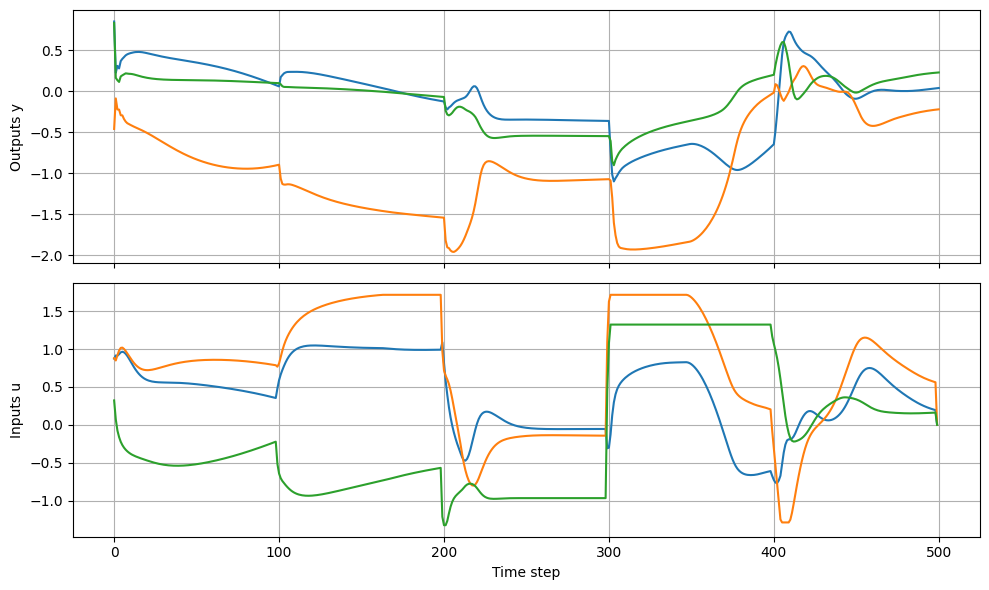

In [20]:
# Simple visualization of outputs and inputs
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(y_sim_ctrl.T)
axs[0].set_ylabel("Outputs y")
axs[0].grid(True)

axs[1].plot(u_sim_ctrl.T)
axs[1].set_ylabel("Inputs u")
axs[1].set_xlabel("Time step")
axs[1].grid(True)

plt.tight_layout()

In [ ]:
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    y_ref_k = reference[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
names = ['T1', 'T2', 'T3']
n_steps = sim_time
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
us_sim_ns = scalerU.inverse_transform(us_sim.T).T
y_pred_ns = scaler.inverse_transform(y_pred.T).T
y_projected = get_y_vector(T_real @ z_sim[:nz,:])
y_projected_ns = scaler.inverse_transform(y_projected).T

fig, axs = plt.subplots(min(8, ny), 1, figsize=(12, 2.5*min(8, ny)), sharex=True)
if min(8, ny) == 1:
    axs = [axs]  # ensure axs is iterable even for 1 plot

for i in range(min(8, ny)):
    ax = axs[i]
    ax.plot(y_sim_descaled[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
        ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    ax.plot(y_pred_ns[i, :n_steps], 'g--', label=f'{names[i]} pred')
    ax.plot(y_projected_ns[i, :n_steps], 'b--', label=f'{names[i]} projected')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0, 1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'q_h', 'P']
for i in range(3):
    axs[i].plot(u_sim_descaled[i, :], label=input_names[i])
    axs[i].plot(us_sim_ns[i, :], 'r--', label=f"{input_names[i]} ref")
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#412
#627
#398
#846
#438